In [1]:
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, broom, zoo, hrbrthemes)
theme_set(lal_plot_theme_d())

options(repr.plot.width = 15, repr.plot.height = 12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "broom"      TRUE  
[7,] "zoo"        TRUE  
[8,] "hrbrthemes" TRUE  


# Covidtracking Project data viz
https://covidtracking.com/api

In [2]:
system("rm -f data/daily.csv")
system("curl https://covidtracking.com/api/v1/states/daily.csv > data/daily.csv")

In [3]:
state_tests = fread('data/daily.csv')
state_tests[, d := anydate(date)]
state_tests[, day := weekdays(d)]
dropcols = c('hash', 'dateChecked')
state_tests[, (dropcols) := NULL]
state_tests %>% glimpse()

Rows: 4,889
Columns: 27
$ date                     <int> 20200531, 20200531, 20200531, 20200531, 2020…
$ state                    <chr> "AK", "AL", "AR", "AS", "AZ", "CA", "CO", "C…
$ positive                 <int> 434, 17903, 7253, 0, 19936, 110583, 26098, 4…
$ negative                 <int> 51261, 199650, 122262, 174, 205270, 1834265,…
$ pending                  <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, 1332…
$ hospitalizedCurrently    <int> 14, NA, 115, NA, 973, 4331, 414, 481, 295, 1…
$ hospitalizedCumulative   <int> NA, 1844, 711, NA, 2998, NA, 4333, 12538, NA…
$ inIcuCurrently           <int> NA, NA, NA, NA, 376, 1324, NA, NA, 109, NA, …
$ inIcuCumulative          <int> NA, 589, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ onVentilatorCurrently    <int> 2, NA, 27, NA, 239, NA, NA, NA, 66, NA, NA, …
$ onVentilatorCumulative   <int> NA, 355, 123, NA, NA, NA, NA, NA, NA, NA, NA…
$ recovered                <int> 368, 9355, 5275, NA, 4761, NA, 3919, 7127, 1…
$ dataQualityGrade         <

In [4]:
state_tests[, tpr := positive / totalTestResults]
state_tests[, cfr := death / positive ]
state_tests[, tpr_new := positiveIncrease / totalTestResultsIncrease]
(most_affected = 
     state_tests[d == max(state_tests$d)][
    order(-positive)][
    1:10, 
    c("state", "d", "positive", "death", "positiveIncrease", "deathIncrease", 
      'totalTestResults', 'totalTestResultsIncrease', 'cfr',  'tpr', 'tpr_new')]
 )

state,d,positive,death,positiveIncrease,deathIncrease,totalTestResults,totalTestResultsIncrease,cfr,tpr,tpr_new
<chr>,<date>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
NY,2020-05-31,370770,23905,1110,57,2063825,58444,0.06447,0.17965,0.01899
NJ,2020-05-31,160445,11698,837,64,746145,837,0.07291,0.21503,1.00000
IL,2020-05-31,120260,5390,1343,60,898259,21154,0.04482,0.13388,0.06349
CA,2020-05-31,110583,4213,3705,57,1944848,56253,0.03810,0.05686,0.06586
MA,2020-05-31,96965,6846,664,78,592853,10334,0.07060,0.16356,0.06425
PA,2020-05-31,72546,5555,515,18,455657,7885,0.07657,0.15921,0.06531
TX,2020-05-31,64287,1672,1949,46,951865,23348,0.02601,0.06754,0.08348
MI,2020-05-31,57397,5491,513,28,554630,15818,0.09567,0.10349,0.03243
FL,2020-05-31,56163,2534,739,4,1021349,26381,0.04512,0.05499,0.02801


In [5]:
t10states = state_tests[positive >= 10 & state %in% most_affected$state]

In [6]:
setorder(t10states, state, date)

smoothvars = c("positive", "hospitalizedCurrently", "cfr", "death", "totalTestResults", 
              "positiveIncrease", "hospitalizedIncrease", "deathIncrease", "totalTestResultsIncrease",
              'tpr', 'tpr_new')

t10states[, paste0("rm3_", smoothvars) := lapply(.SD, rollmean, k = 3, fill = NA, na.pad = T), 
   by = .(state), .SDcols = smoothvars]

# t10states[, tpr_rm3 := rollmeanr(tpr, 3, fill = NA), by = .(state)]

# Plots 

## Natl Time Series

In [7]:
nat_ts = state_tests[, lapply(.SD, sum, na.rm = T), by = d, 
                     .SDcols = c("positive", "positiveIncrease", "totalTestResults", "totalTestResultsIncrease", "death", "deathIncrease")][, 
    `:=`(cfr = death/positive,
         tpr = positive/totalTestResults,
         tpr_n = positiveIncrease/totalTestResultsIncrease
         )]

smoothvars = c("positive", "positiveIncrease", "death", "deathIncrease", "tpr_n", "cfr", "tpr", "totalTestResultsIncrease")

nat_ts[, paste0("rm3_", smoothvars) := lapply(.SD, rollmean, k = 3, fill = NA, na.pad = T), .SDcols = smoothvars]
nat_ts[, .(d, positive, positiveIncrease, death, deathIncrease, totalTestResults, totalTestResultsIncrease)] %>% head

d,positive,positiveIncrease,death,deathIncrease,totalTestResults,totalTestResultsIncrease
<date>,<int>,<int>,<int>,<int>,<int>,<int>
2020-05-31,1783570,22545,98536,656,16936891,406206
2020-05-30,1761025,24454,97880,989,16530685,431170
2020-05-29,1736571,23934,96891,1186,16099515,492276
2020-05-28,1712637,23007,95705,1353,15607239,414758
2020-05-27,1689630,18595,94352,1259,15192481,285440
2020-05-26,1671035,16206,93093,629,14907041,302099


Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'



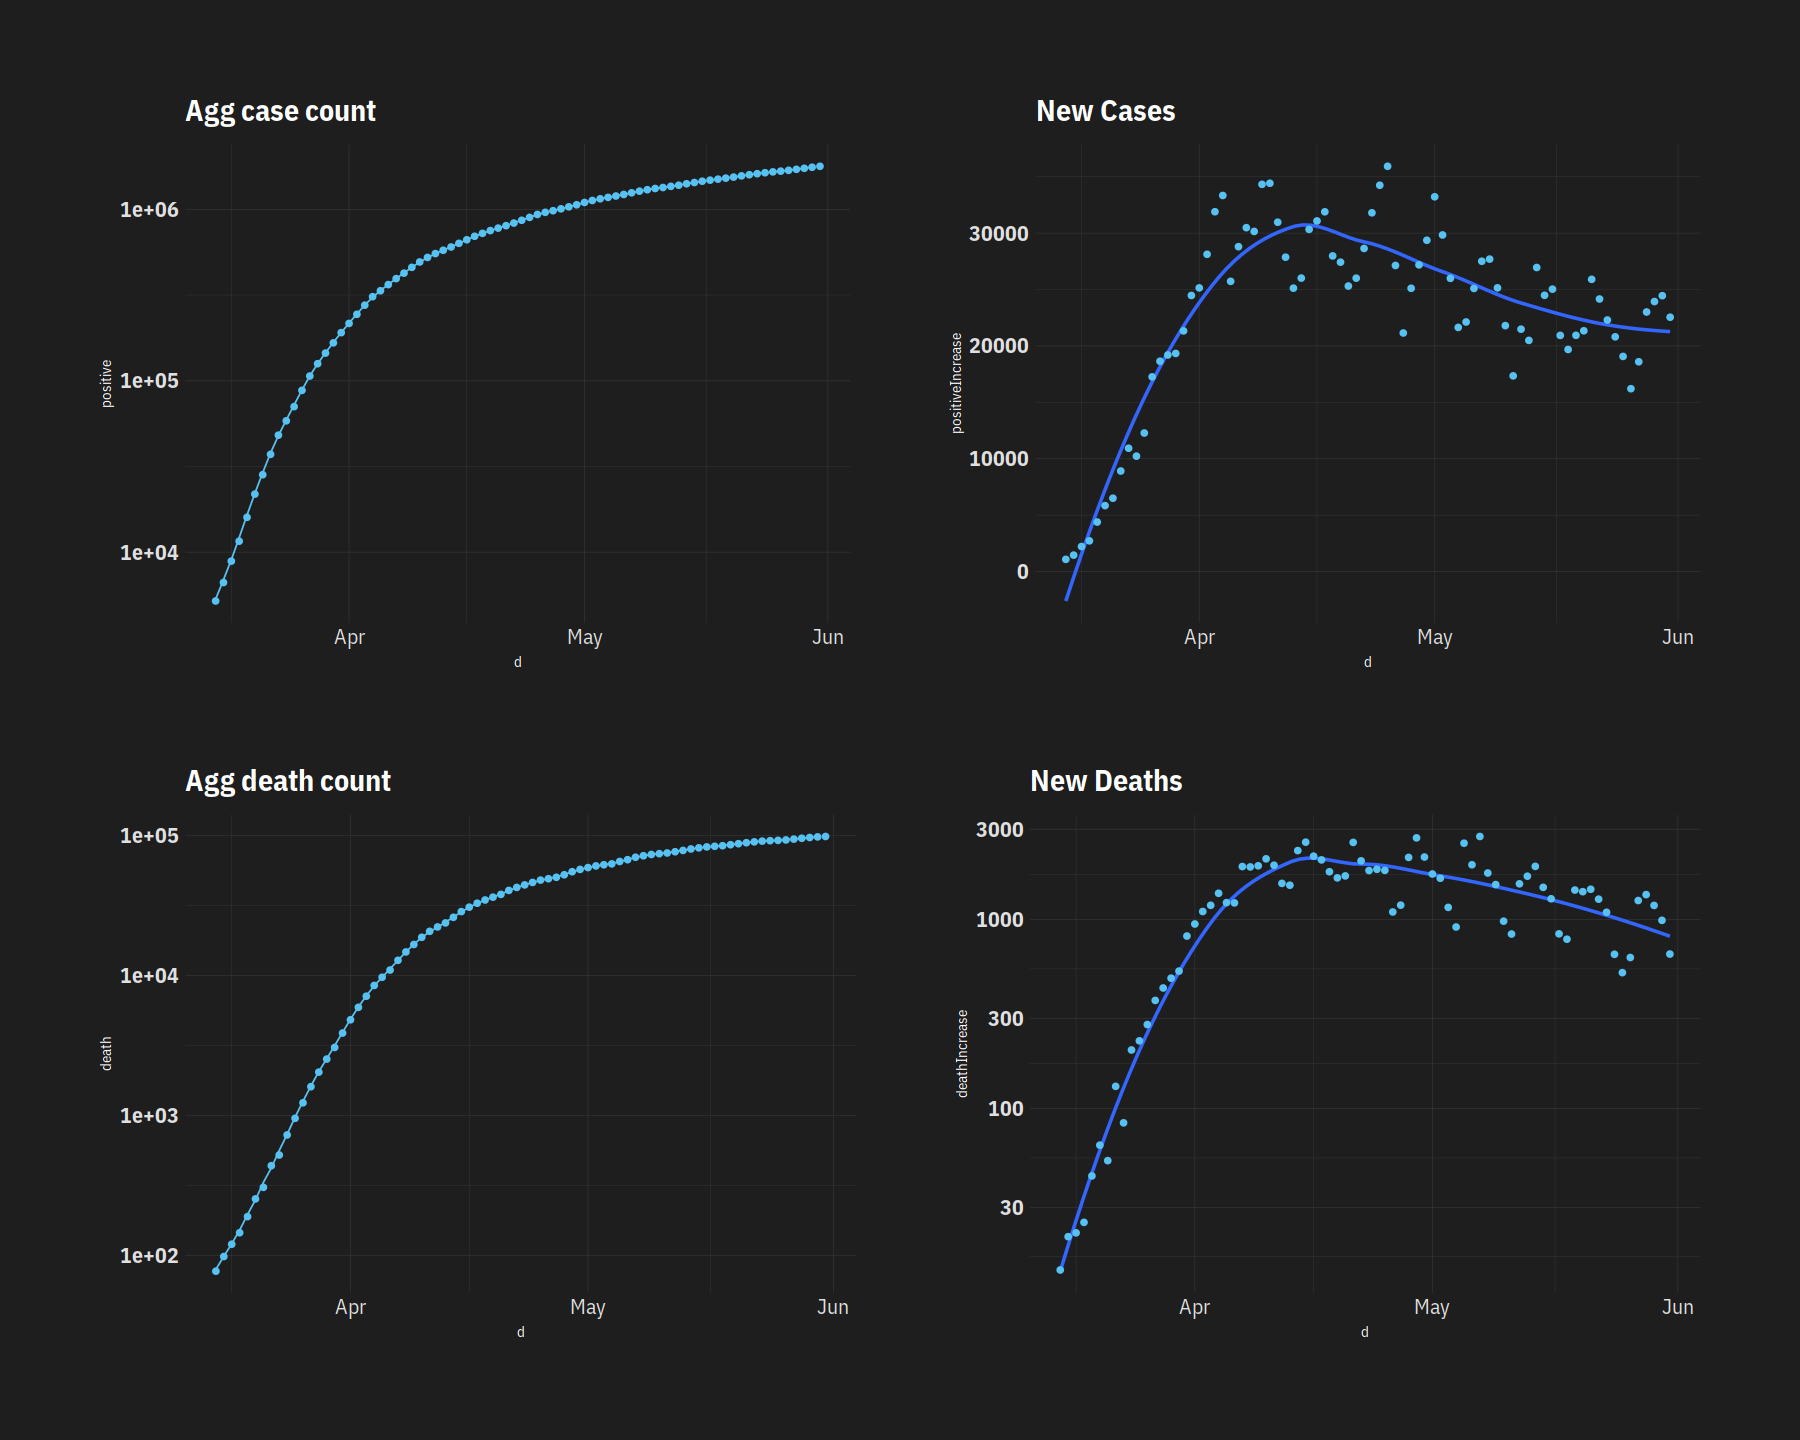

In [8]:
p1 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = positive)) + scale_y_log10() +
    geom_point() + geom_line(aes(y = rm3_positive)) + ggtitle("Agg case count")

p2 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = positiveIncrease)) + geom_smooth(se = F) + 
    geom_point() + ggtitle("New Cases")

p3 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = death)) + scale_y_log10() + geom_line(aes(y = rm3_death)) +
    geom_point() + ggtitle("Agg death count")

p4 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = deathIncrease)) + scale_y_log10() + geom_smooth(se = F) +
    geom_point() + ggtitle("New Deaths")

(p1 | p2)/(p3 | p4)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



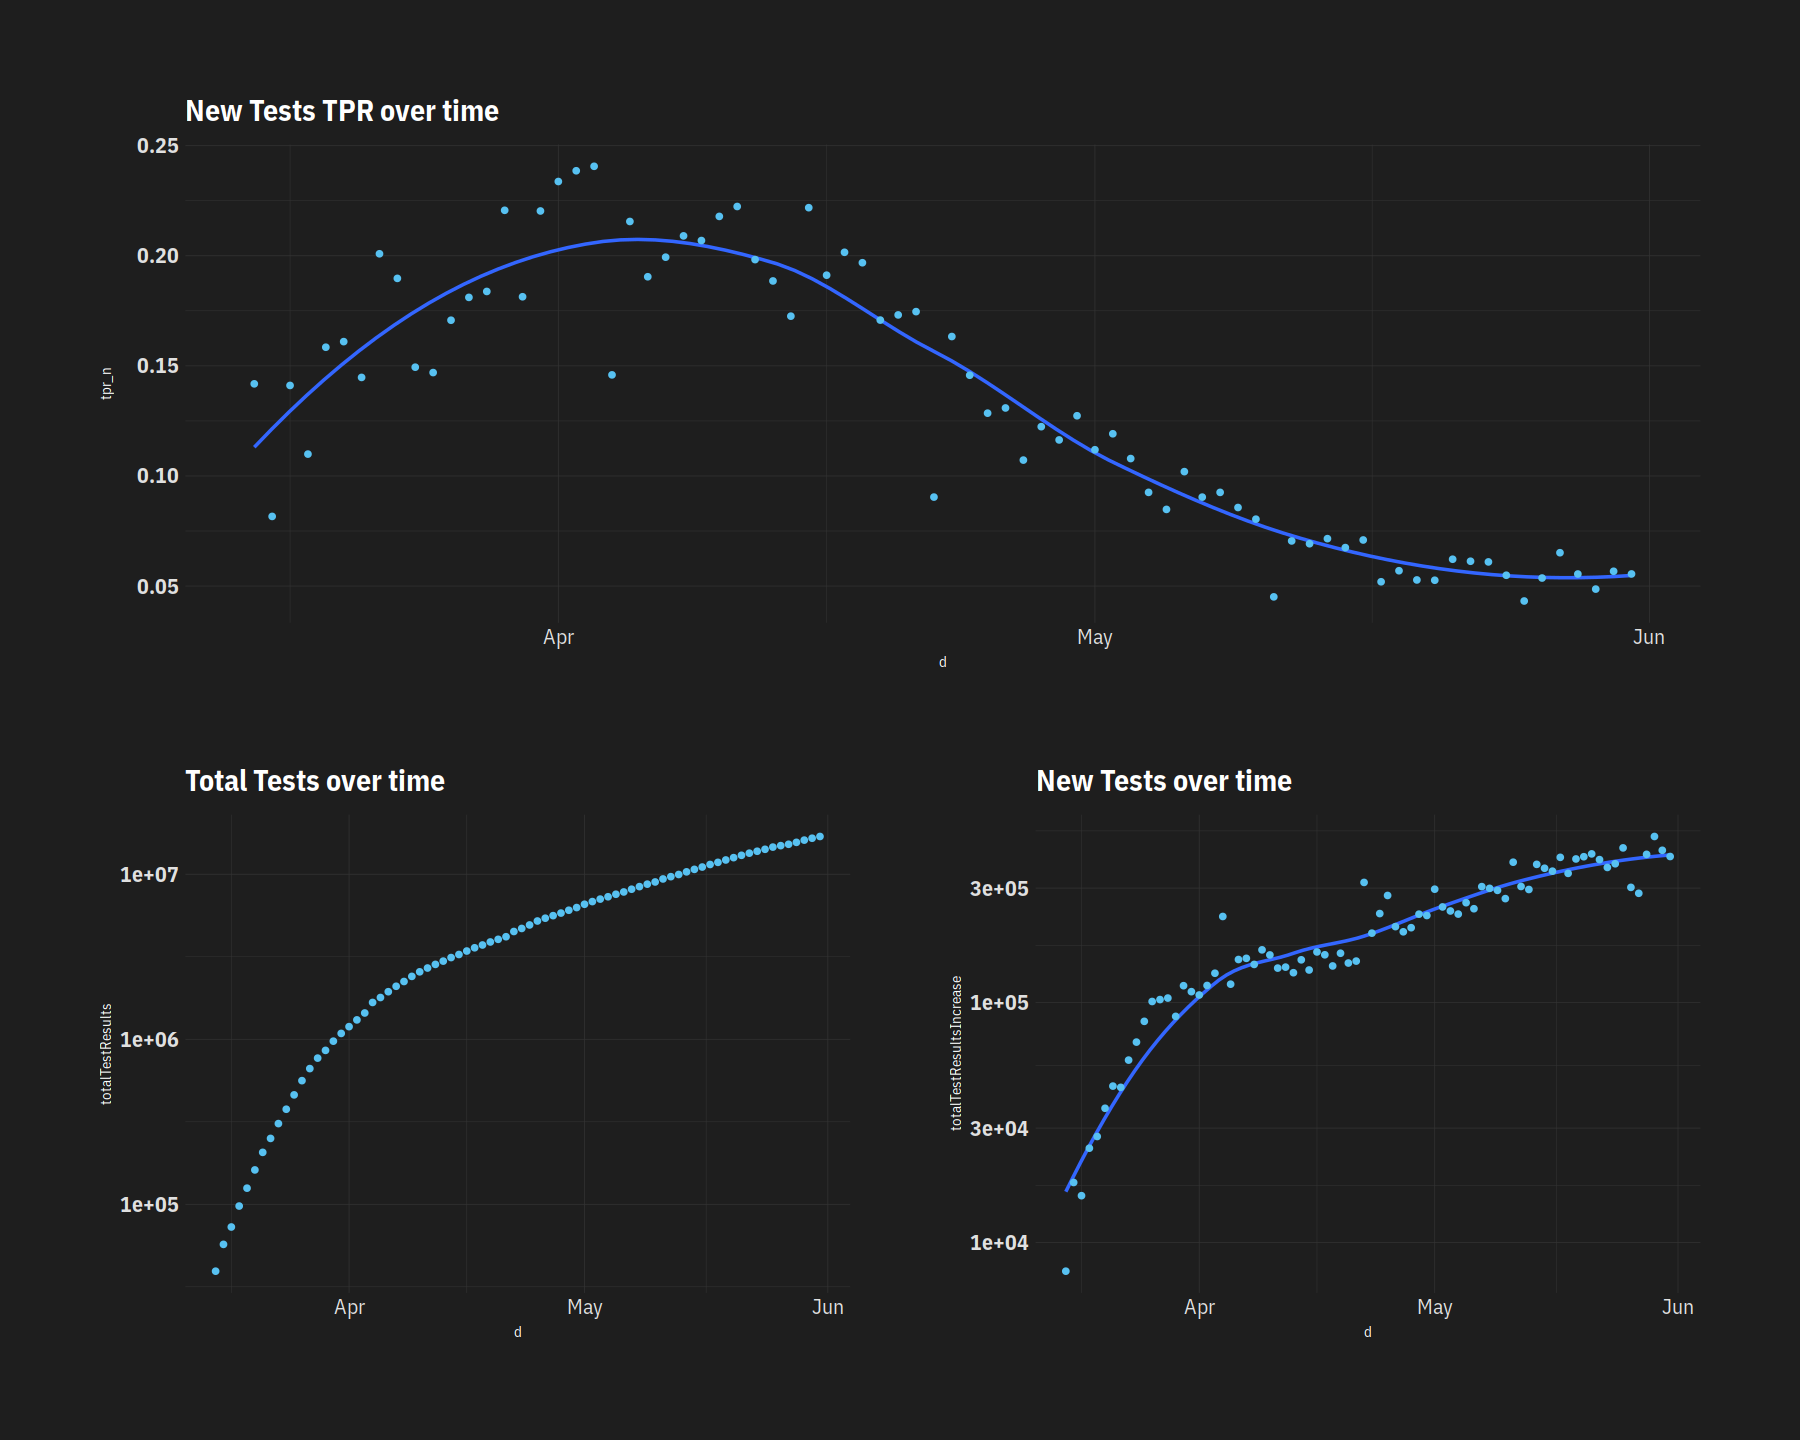

In [9]:
p1 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = tpr)) +
    geom_point() + geom_smooth(se = F) + ggtitle("TPR over time")

p2 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = tpr_n)) + geom_smooth(se = F) +
    geom_point() + ggtitle("New Tests TPR over time")
p3 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = totalTestResults)) + scale_y_log10() +
    geom_point() + ggtitle("Total Tests over time")

p4 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = totalTestResultsIncrease)) + 
    scale_y_log10() + geom_smooth(se = F) +
    geom_point() + ggtitle("New Tests over time")

p5 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = cfr)) + geom_smooth(se = F) +
    geom_point() + ggtitle("CFR Estimate over time")
(p2)/(p3 | p4) # | p5

In [10]:
# generic function to plot time series
plot_ts = function(df, col, t = "Time Series of", logtransform = F, rm = T){
    p = ggplot(df, aes_string(x = 'd', y = col, colour = 'state', group = 'state')) +
        geom_point( size = 0.7) + 
        # plot rolling mean line
        scale_colour_brewer(palette = "Spectral") +
        labs(
            title = t,
            subtitle = paste(unique(df$state), collapse = ", ")
        )
    if (rm == T) {
        p = p + geom_line(aes_string(y = paste0("rm3_", col))) 
    } else{
        p = p + geom_smooth(se = F)
    }
    if (logtransform == T) p = p + scale_y_log10()
    return(p)
}

## Cases 

Warning message:
“Removed 20 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


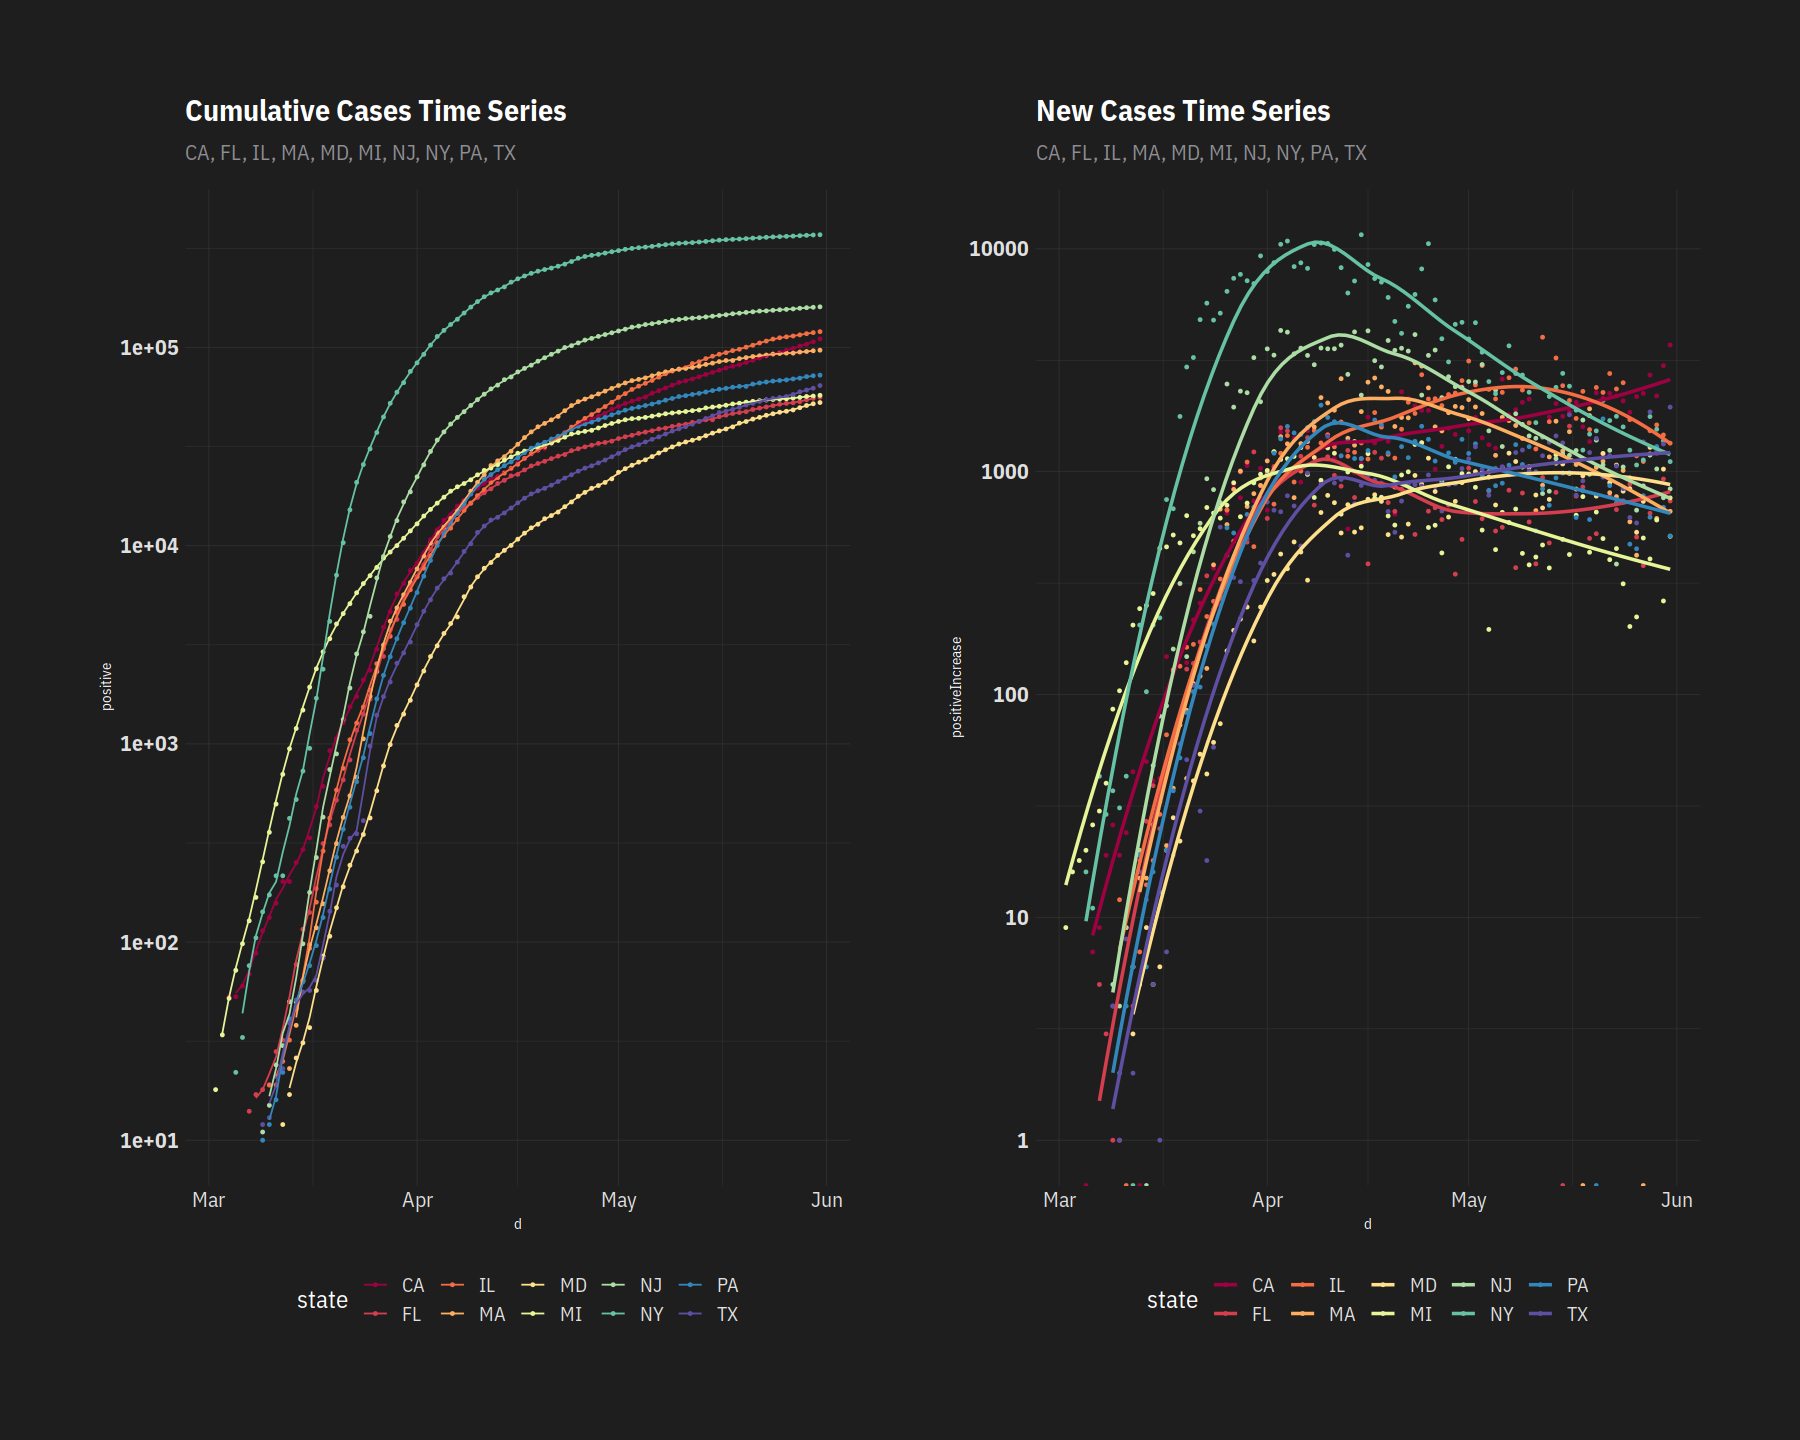

In [11]:
p1 = plot_ts(t10states, 'positive', "Cumulative Cases Time Series", T)
p2 = plot_ts(t10states, 'positiveIncrease', "New Cases Time Series", T, F)
(p1 | p2)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


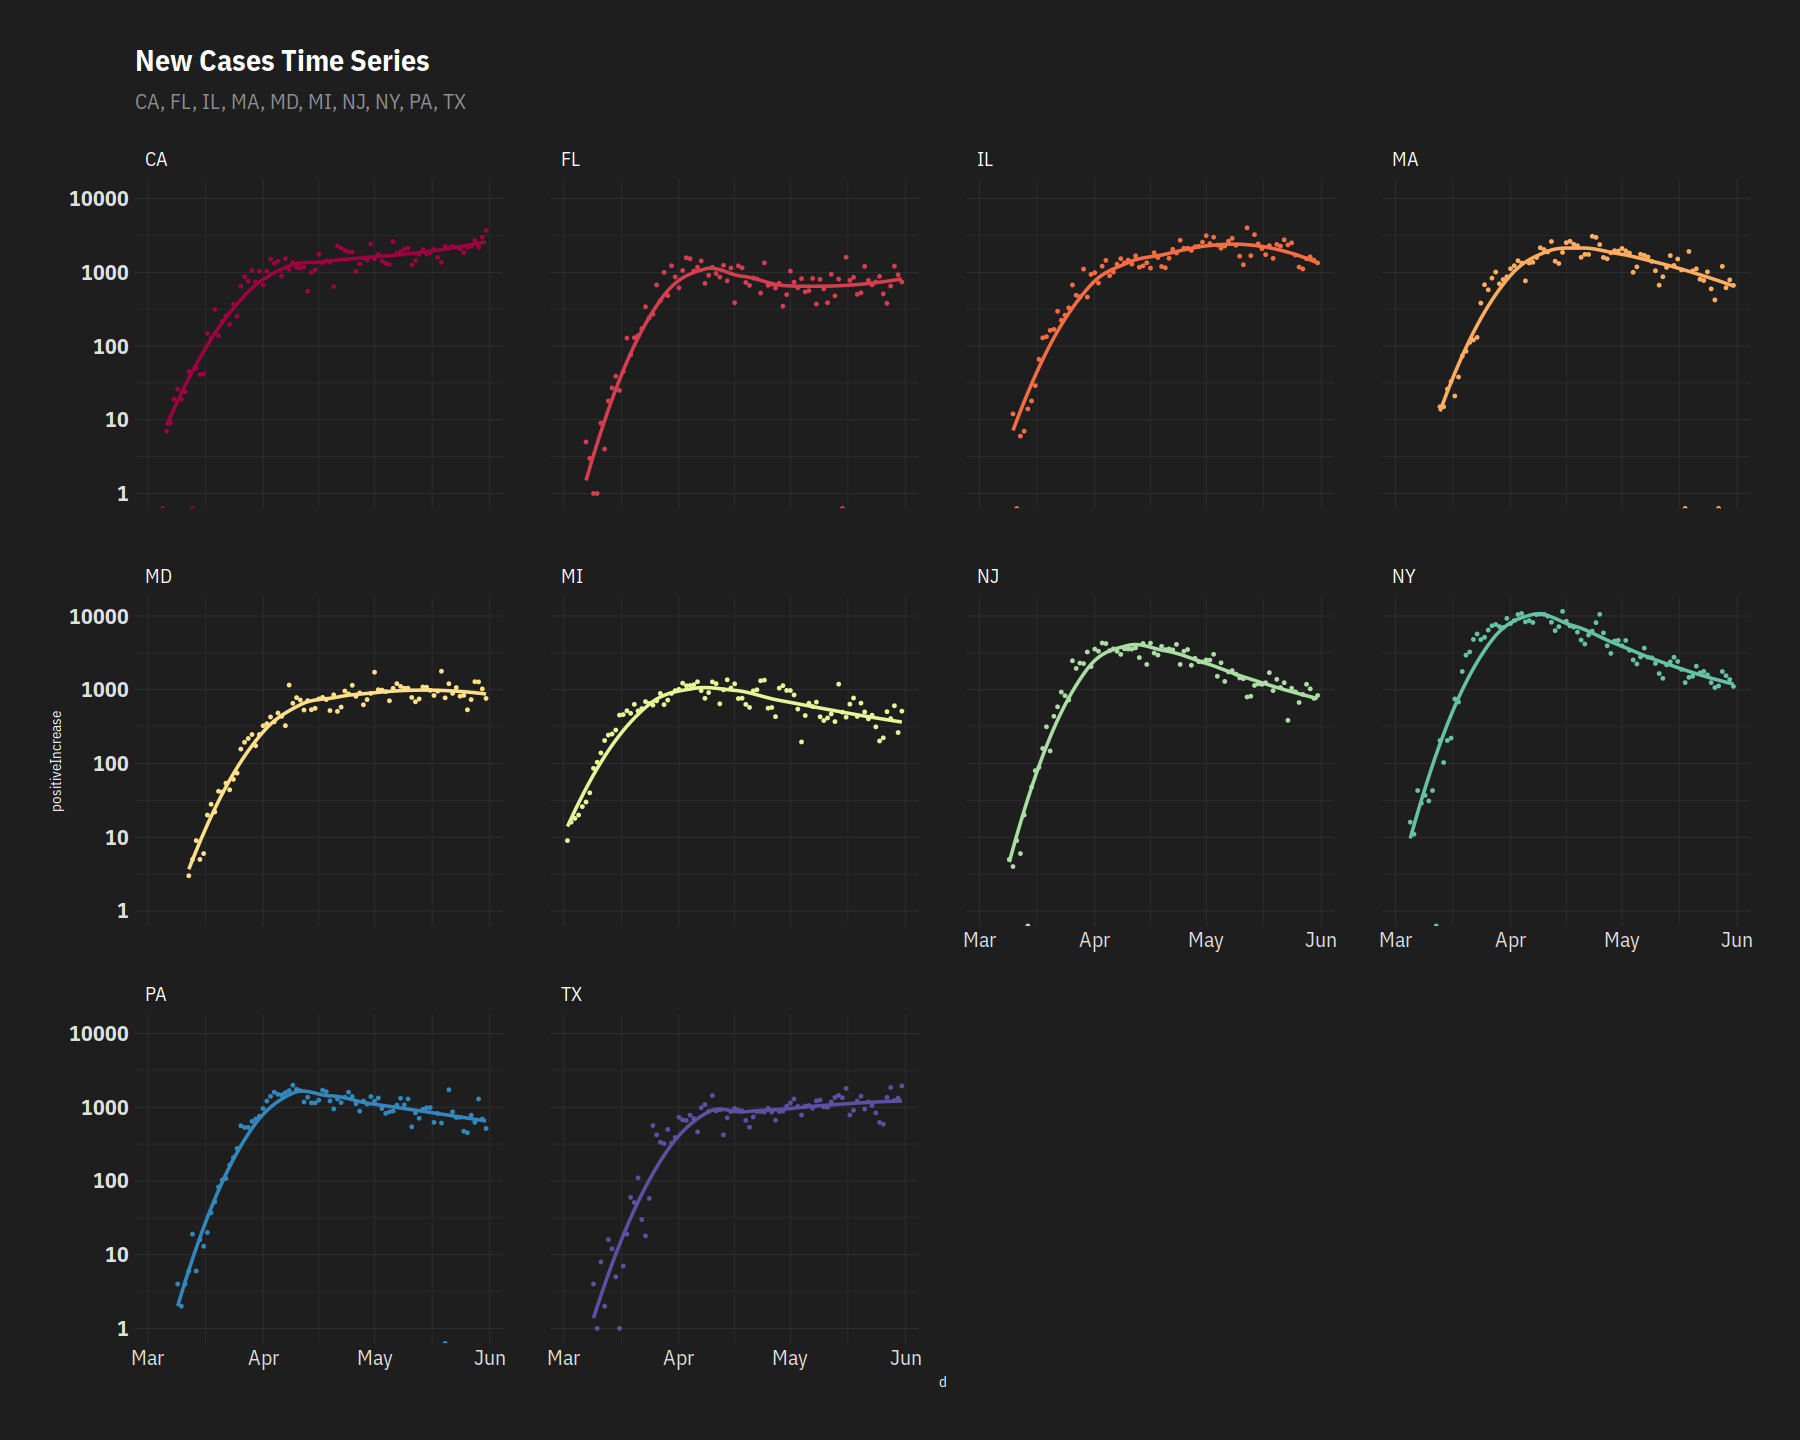

In [12]:
p2 + facet_wrap(~ state) + theme(legend.position = "None")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 77 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 77 rows containing missing values (geom_point).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 112 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


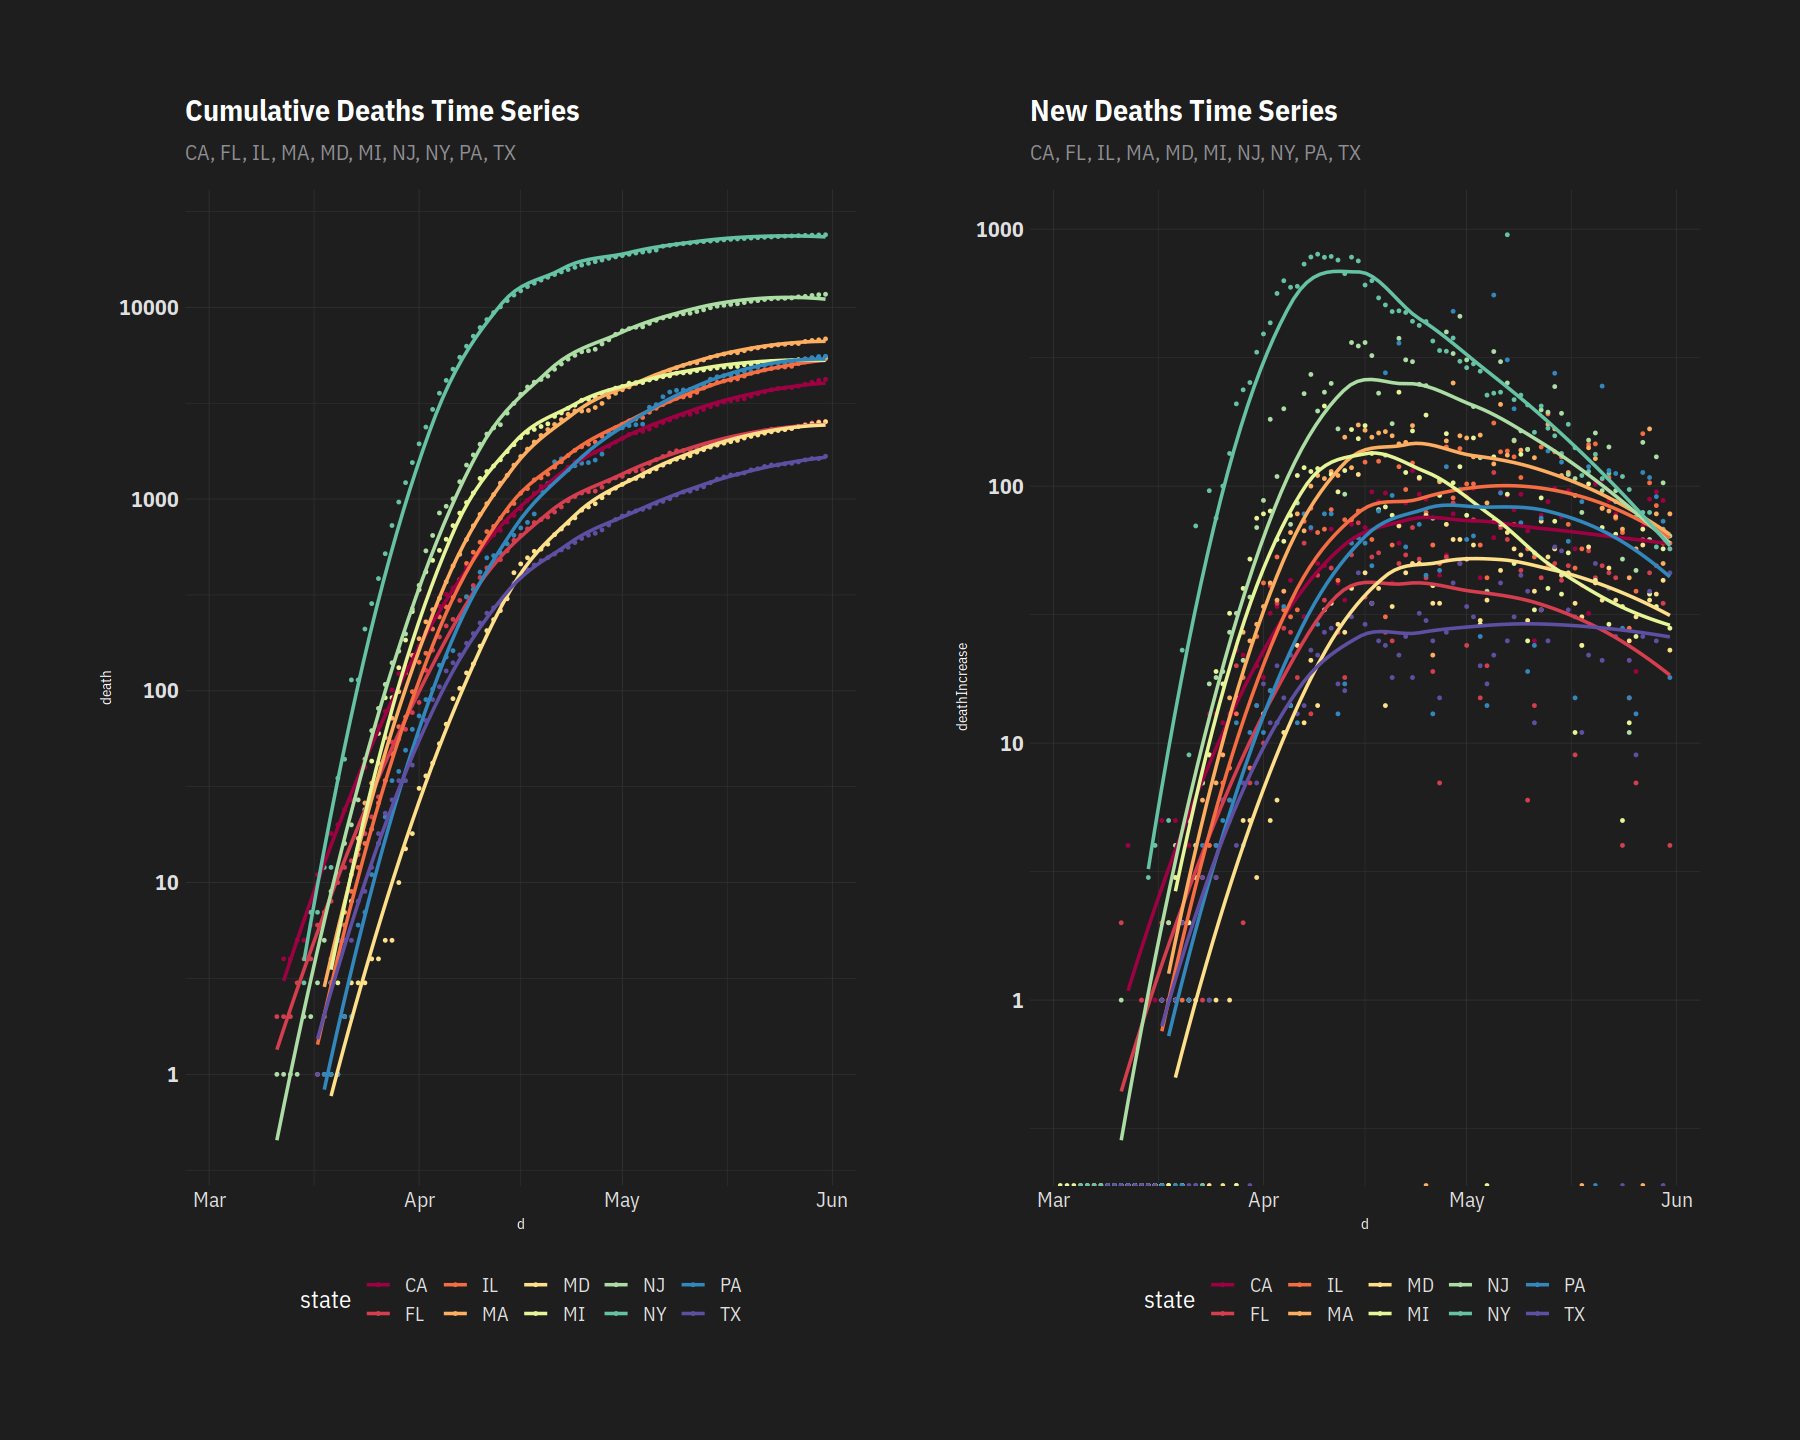

In [13]:
p1 = plot_ts(t10states, 'death', "Cumulative Deaths Time Series", T, F)
p2 = plot_ts(t10states, 'deathIncrease', "New Deaths Time Series", T, F)
(p1 | p2)

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 112 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


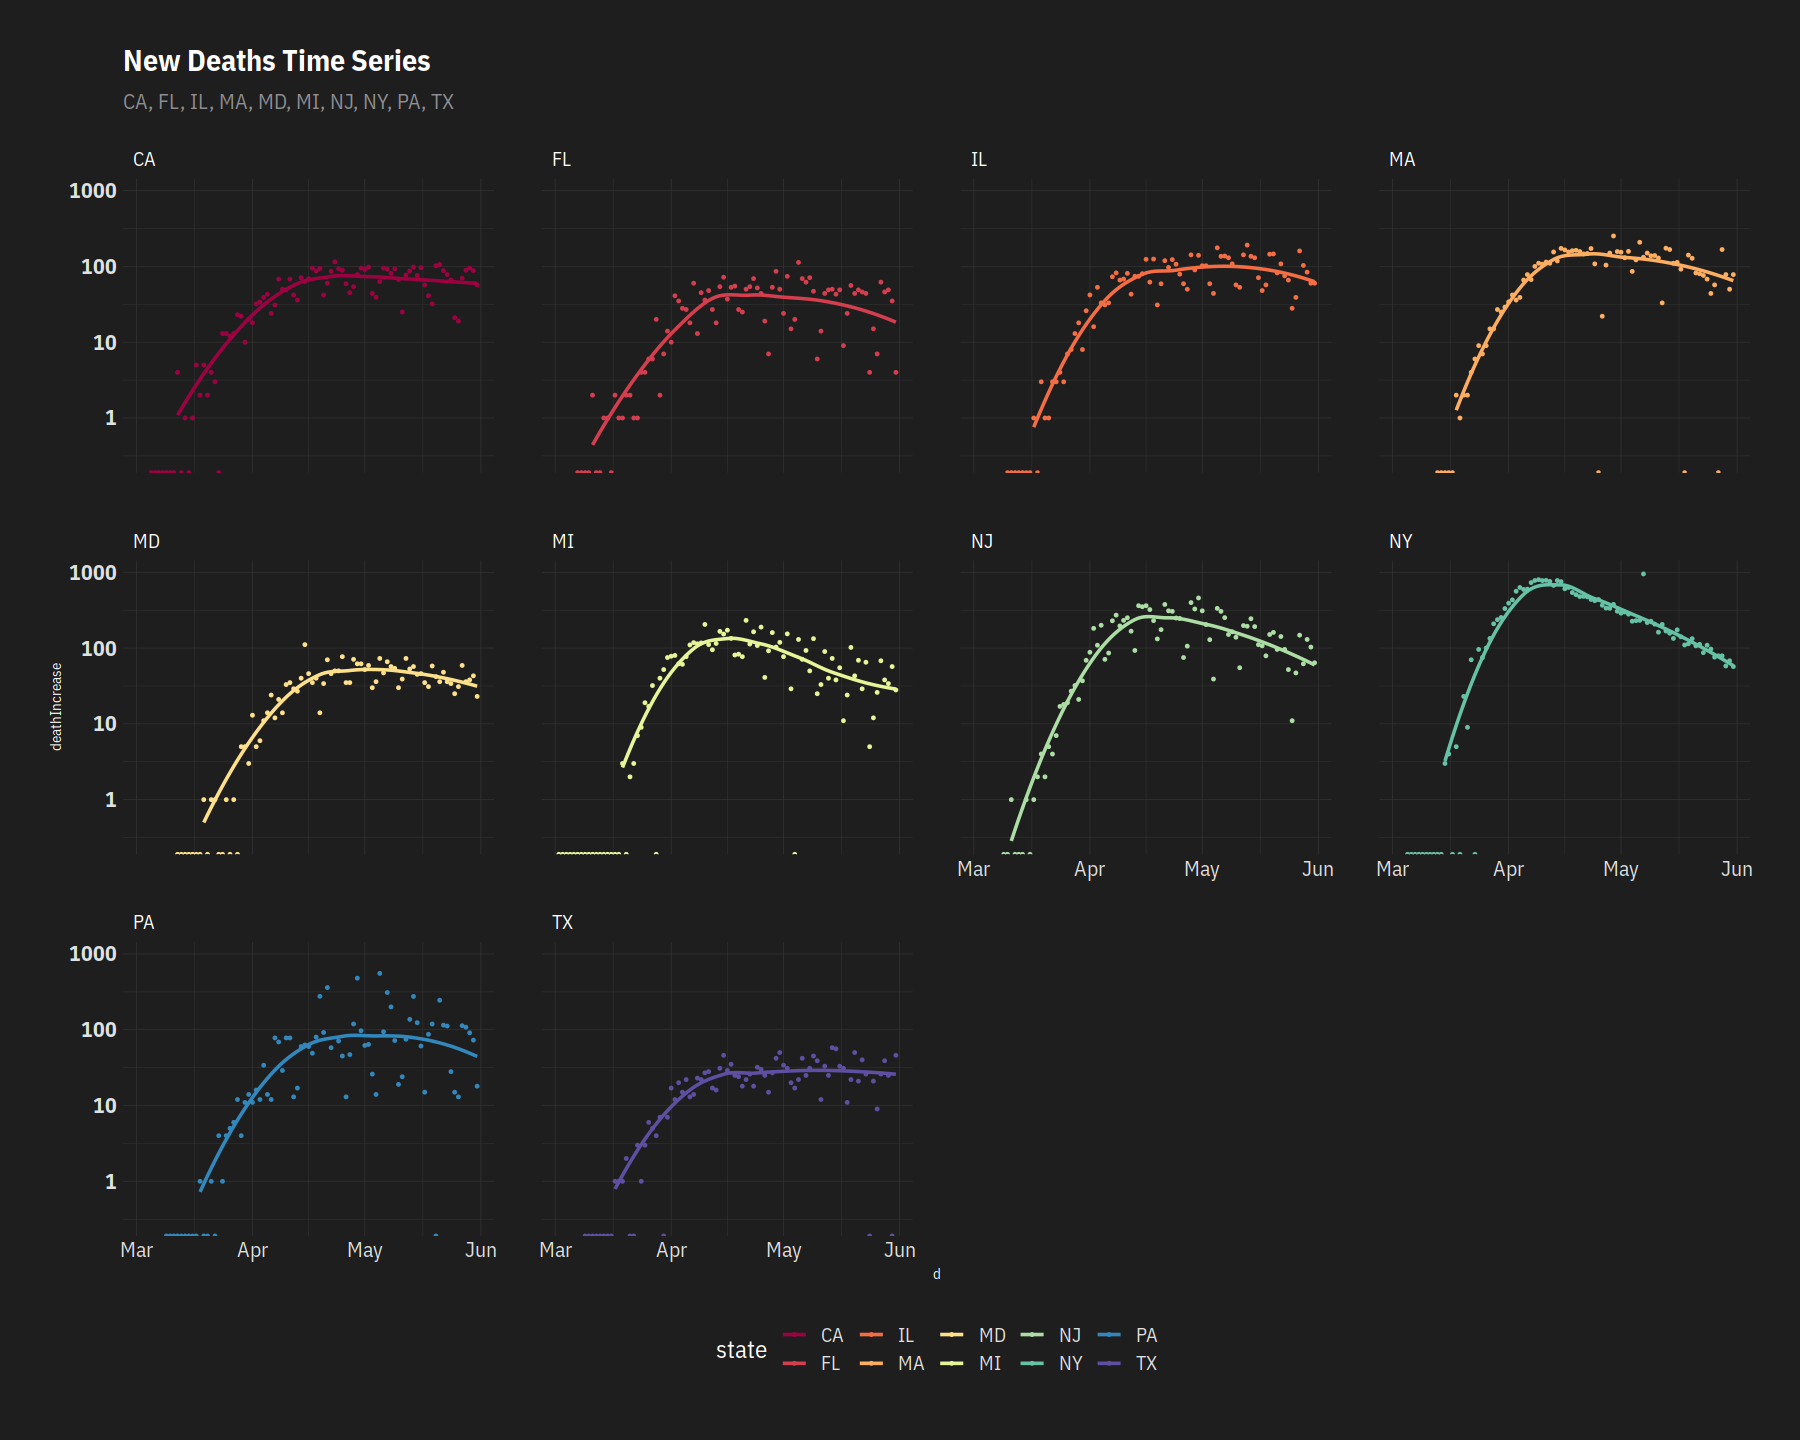

In [14]:
p2 + facet_wrap(~ state) 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 18 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 18 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_smooth).”


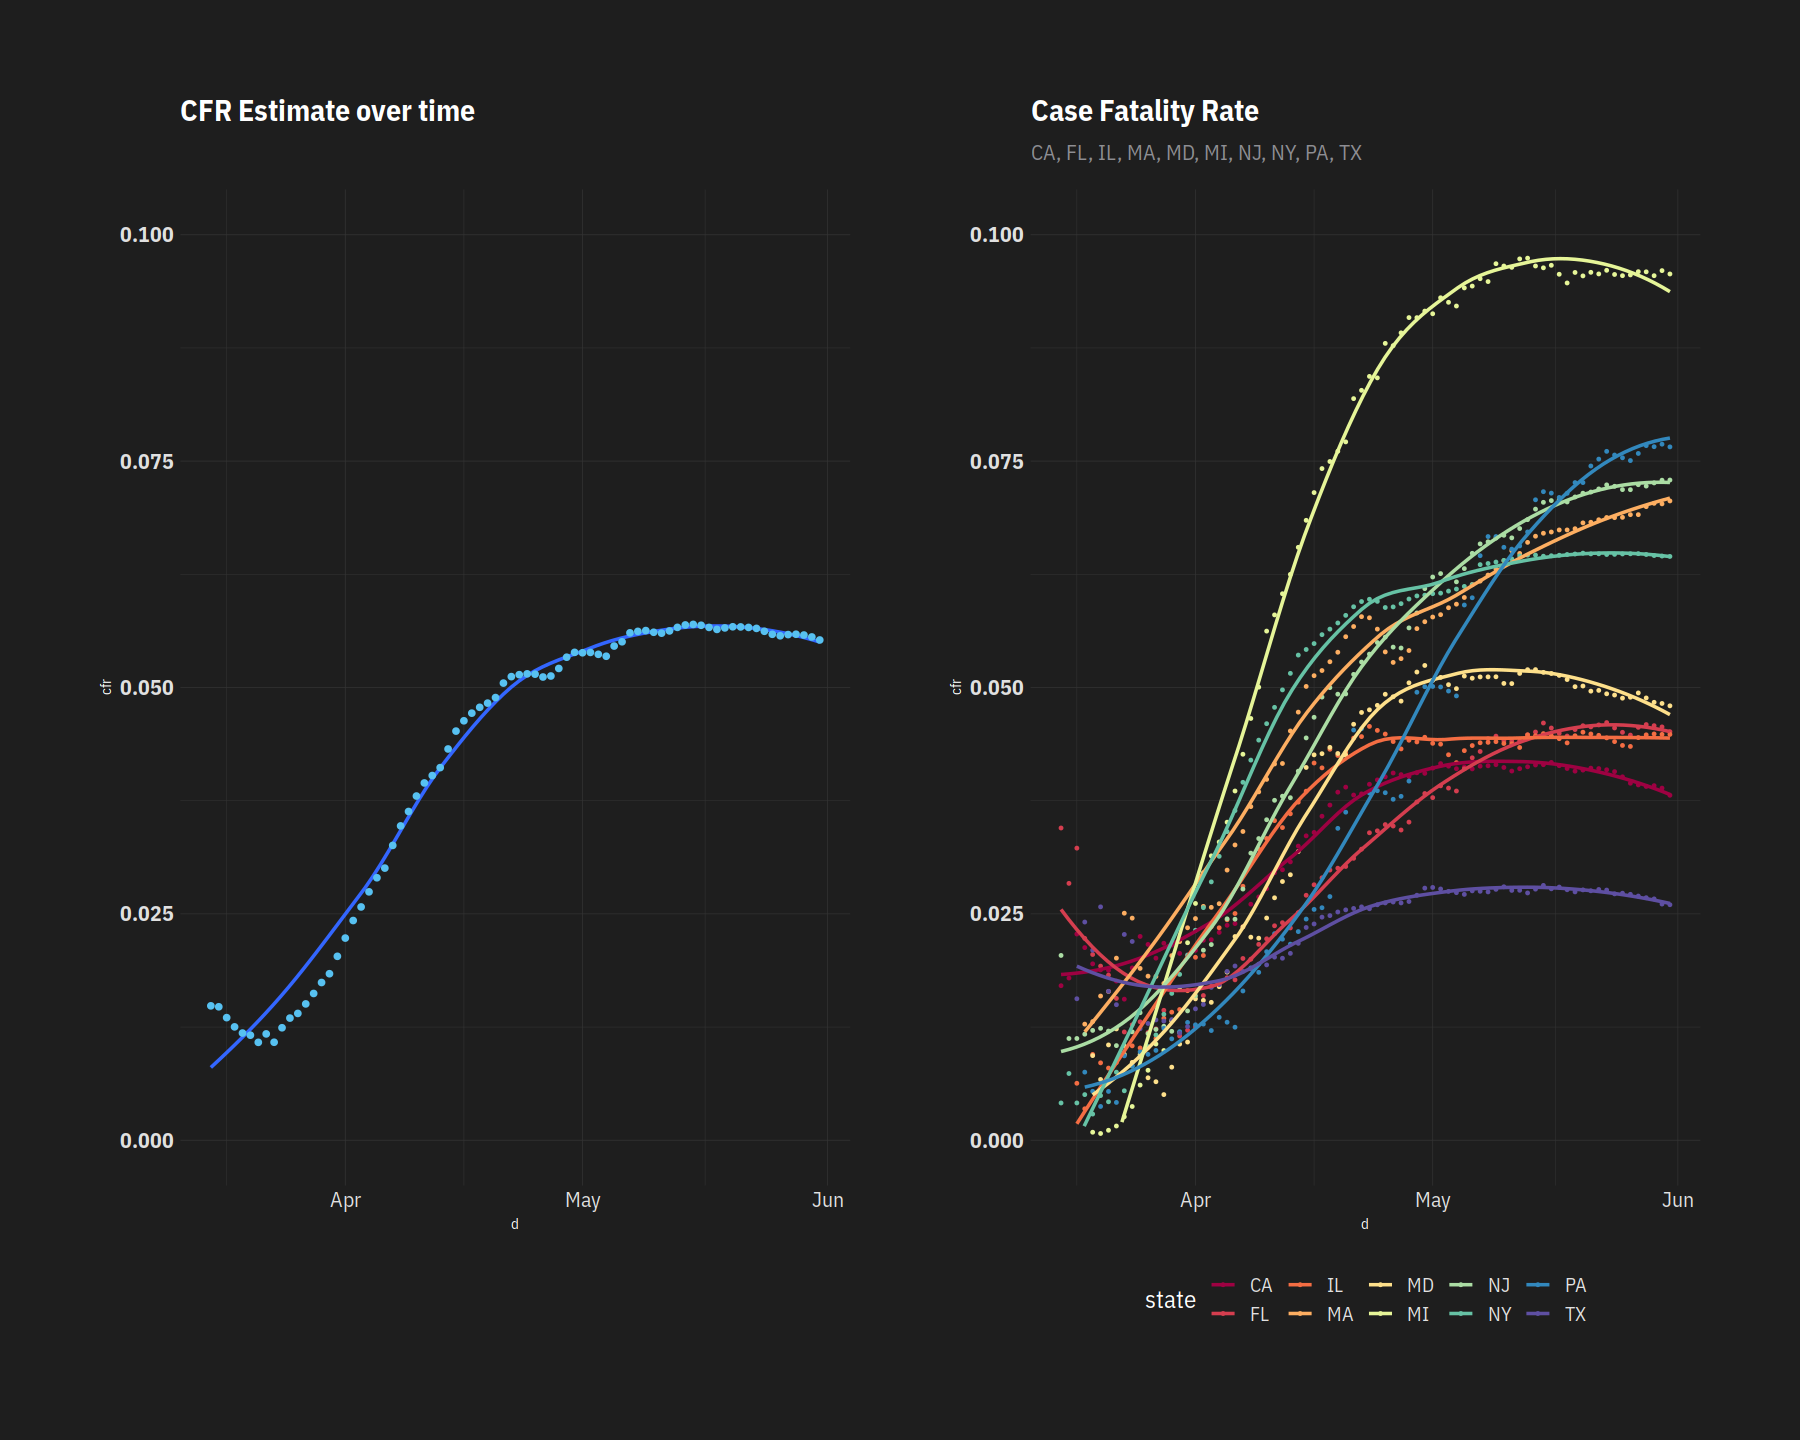

In [15]:
cfp = plot_ts(t10states[d >= "2020-03-15"], "cfr", "Case Fatality Rate", F, F)
p5 + ylim(c(0, 0.1)) | cfp+ ylim(c(0, 0.1)) 

## Tests 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


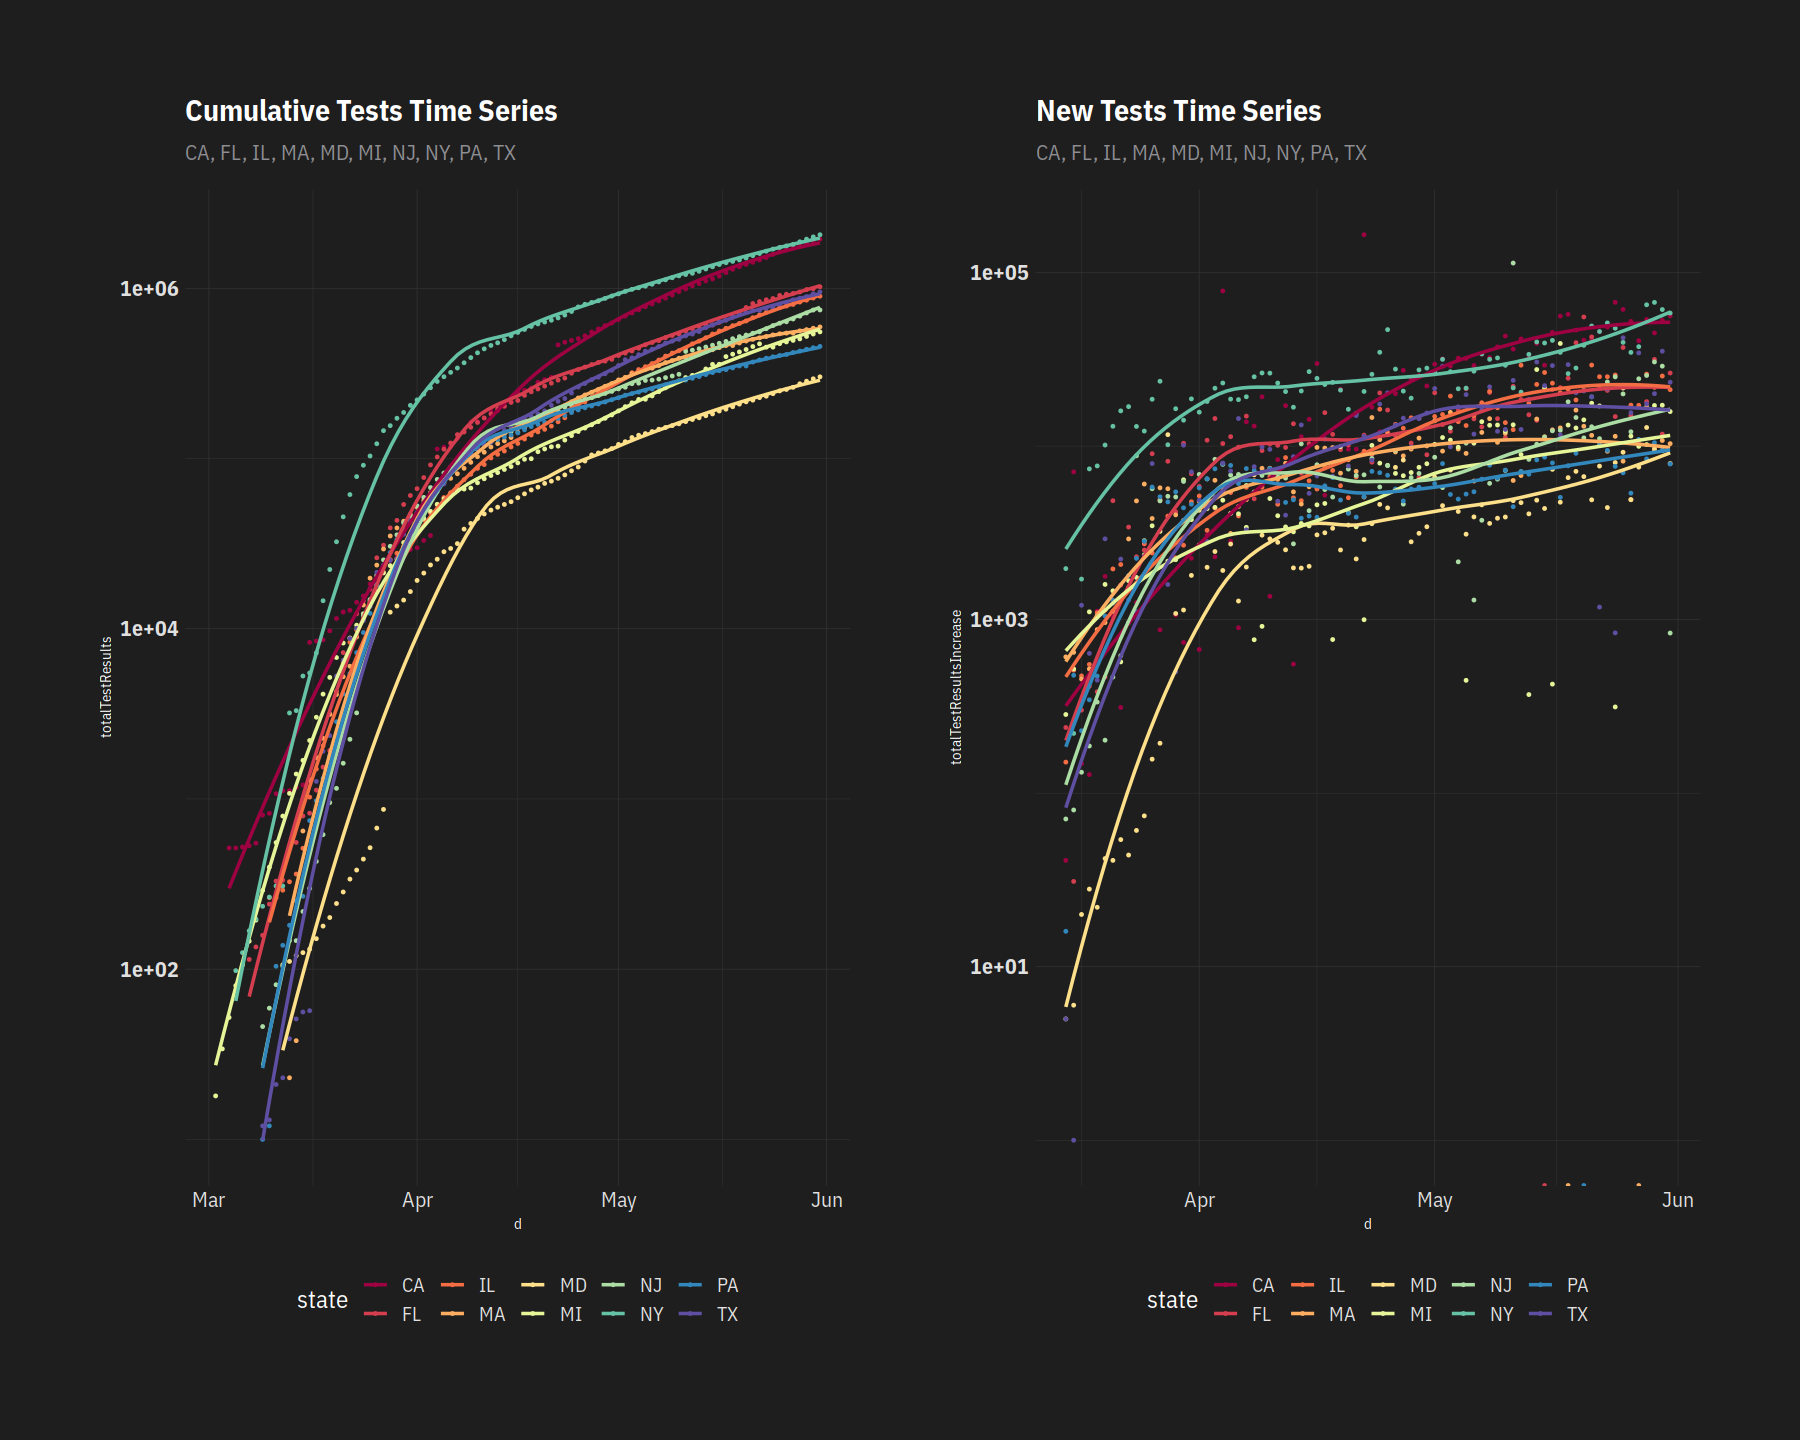

In [16]:
p = plot_ts(t10states, 'totalTestResults', "Cumulative Tests Time Series", T, F)
p2 = plot_ts(t10states[d >= '2020-03-15'], 'totalTestResultsIncrease', "New Tests Time Series", T, F)

(p | p2)

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


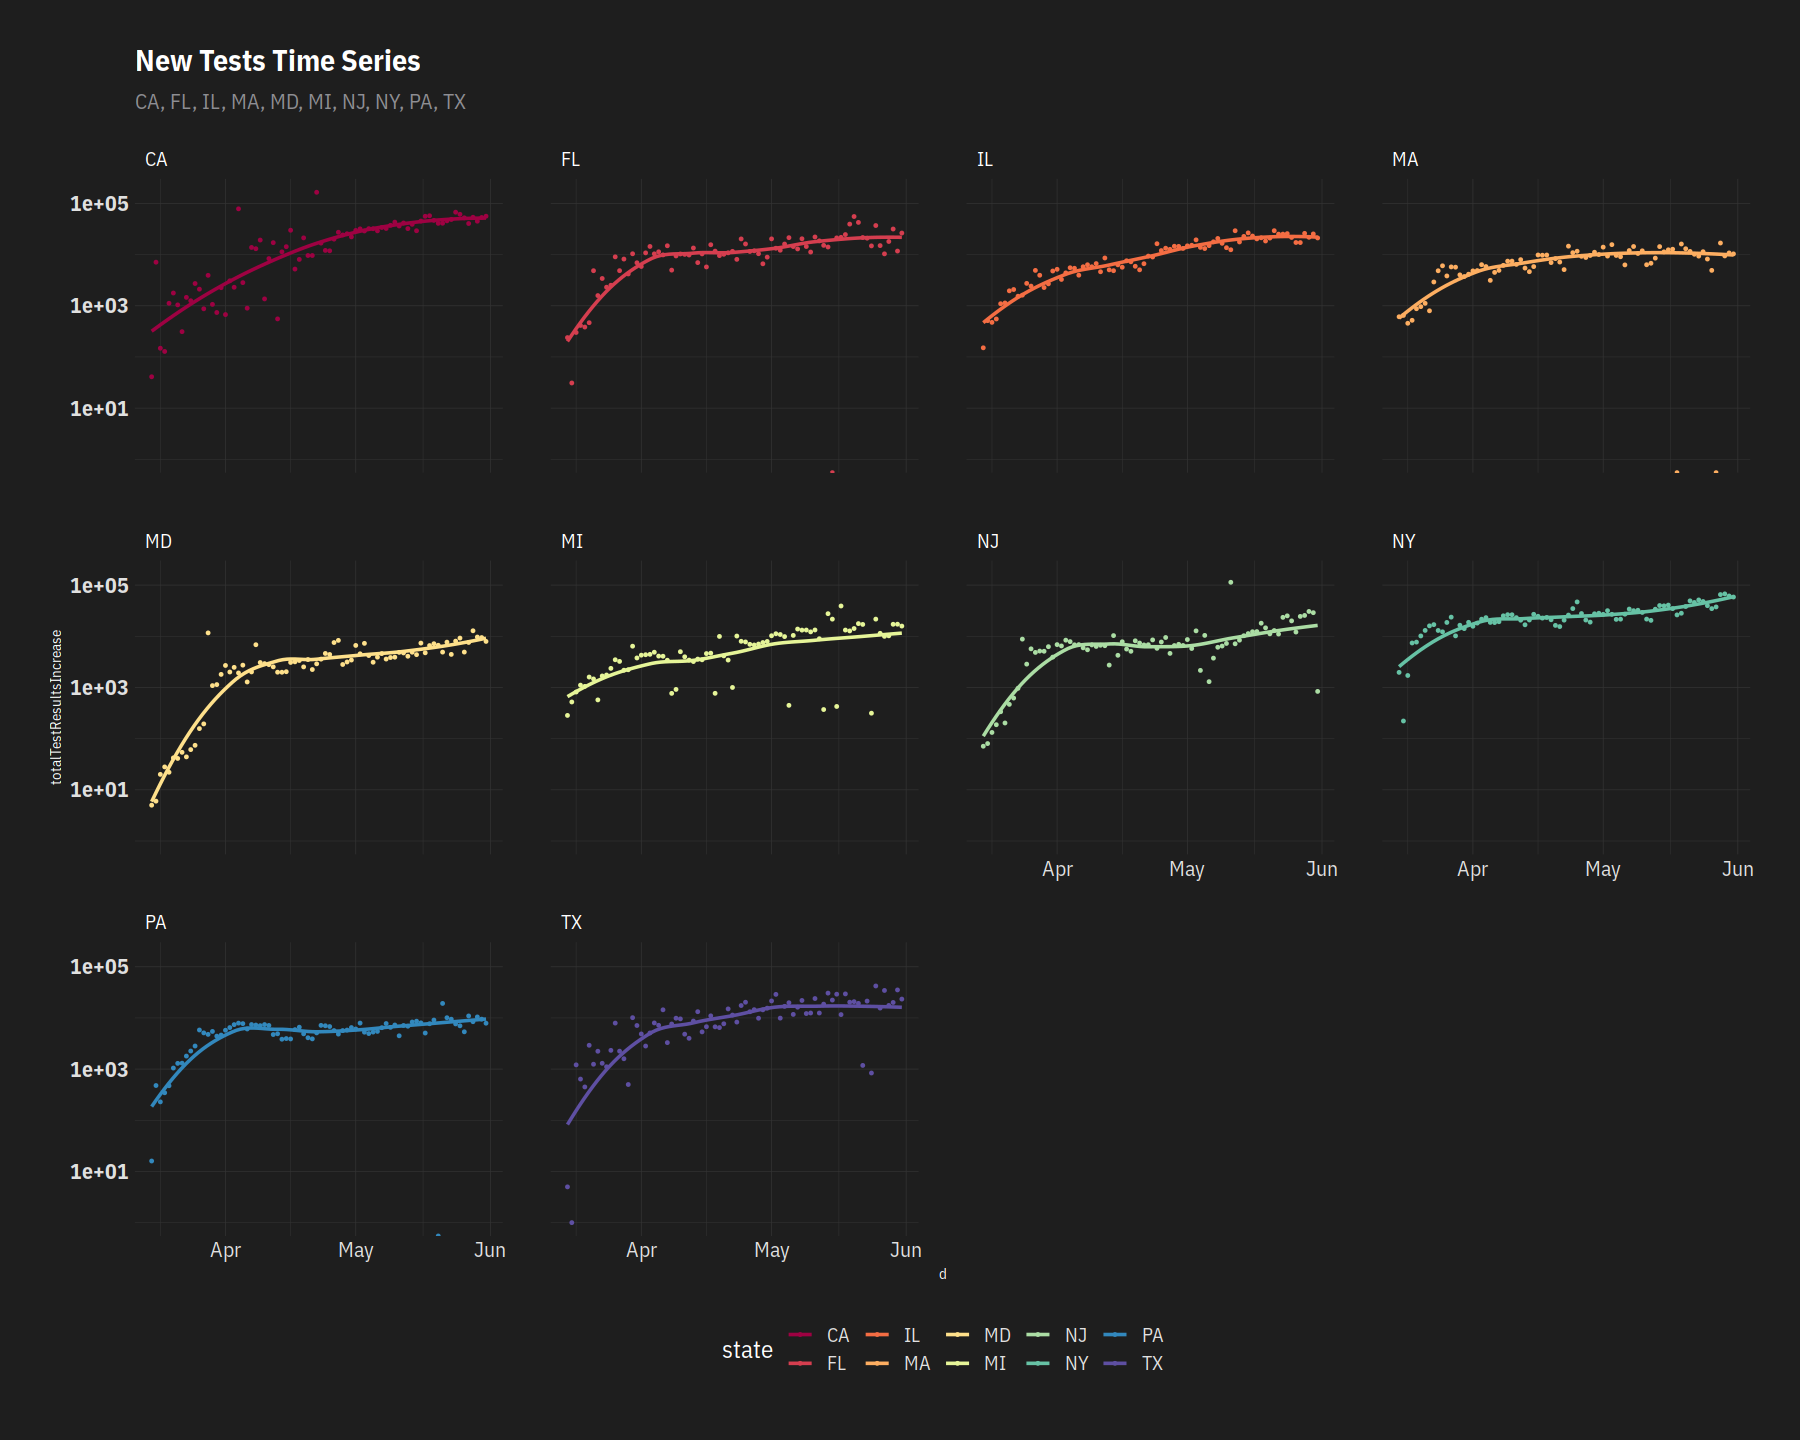

In [17]:
p2 + facet_wrap(~ state) 

# Shares over time  

In [18]:
t10states[, rm3_deathIncrease := ifelse(rm3_deathIncrease < 0, 0, deathIncrease)]
t10states[, rm3_totalTestResultsIncrease := ifelse(rm3_totalTestResultsIncrease < 0, 0, rm3_totalTestResultsIncrease)]

t10states[, denom_cases := sum(rm3_positiveIncrease), by = d][, 
            denom_deaths := sum(rm3_deathIncrease), by = d]
t10states[, newcase_share := rm3_positiveIncrease / denom_cases][, 
            newdeath_share := rm3_deathIncrease/denom_deaths]

t10states[, rm3_totalTestResultsIncrease := ifelse(rm3_totalTestResultsIncrease < 0, 0, rm3_totalTestResultsIncrease)]
t10states[, denom_tests := sum(rm3_totalTestResultsIncrease), by = d]
t10states[, tests_share := rm3_totalTestResultsIncrease / denom_tests]

In [19]:
t10states[, stgroup := case_when(
    state %in% c("NY", "NJ", "MA", "CT", "PA") ~ paste0("1_", state), # group northeast
    TRUE ~ paste0("2_", state)
)]

Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”


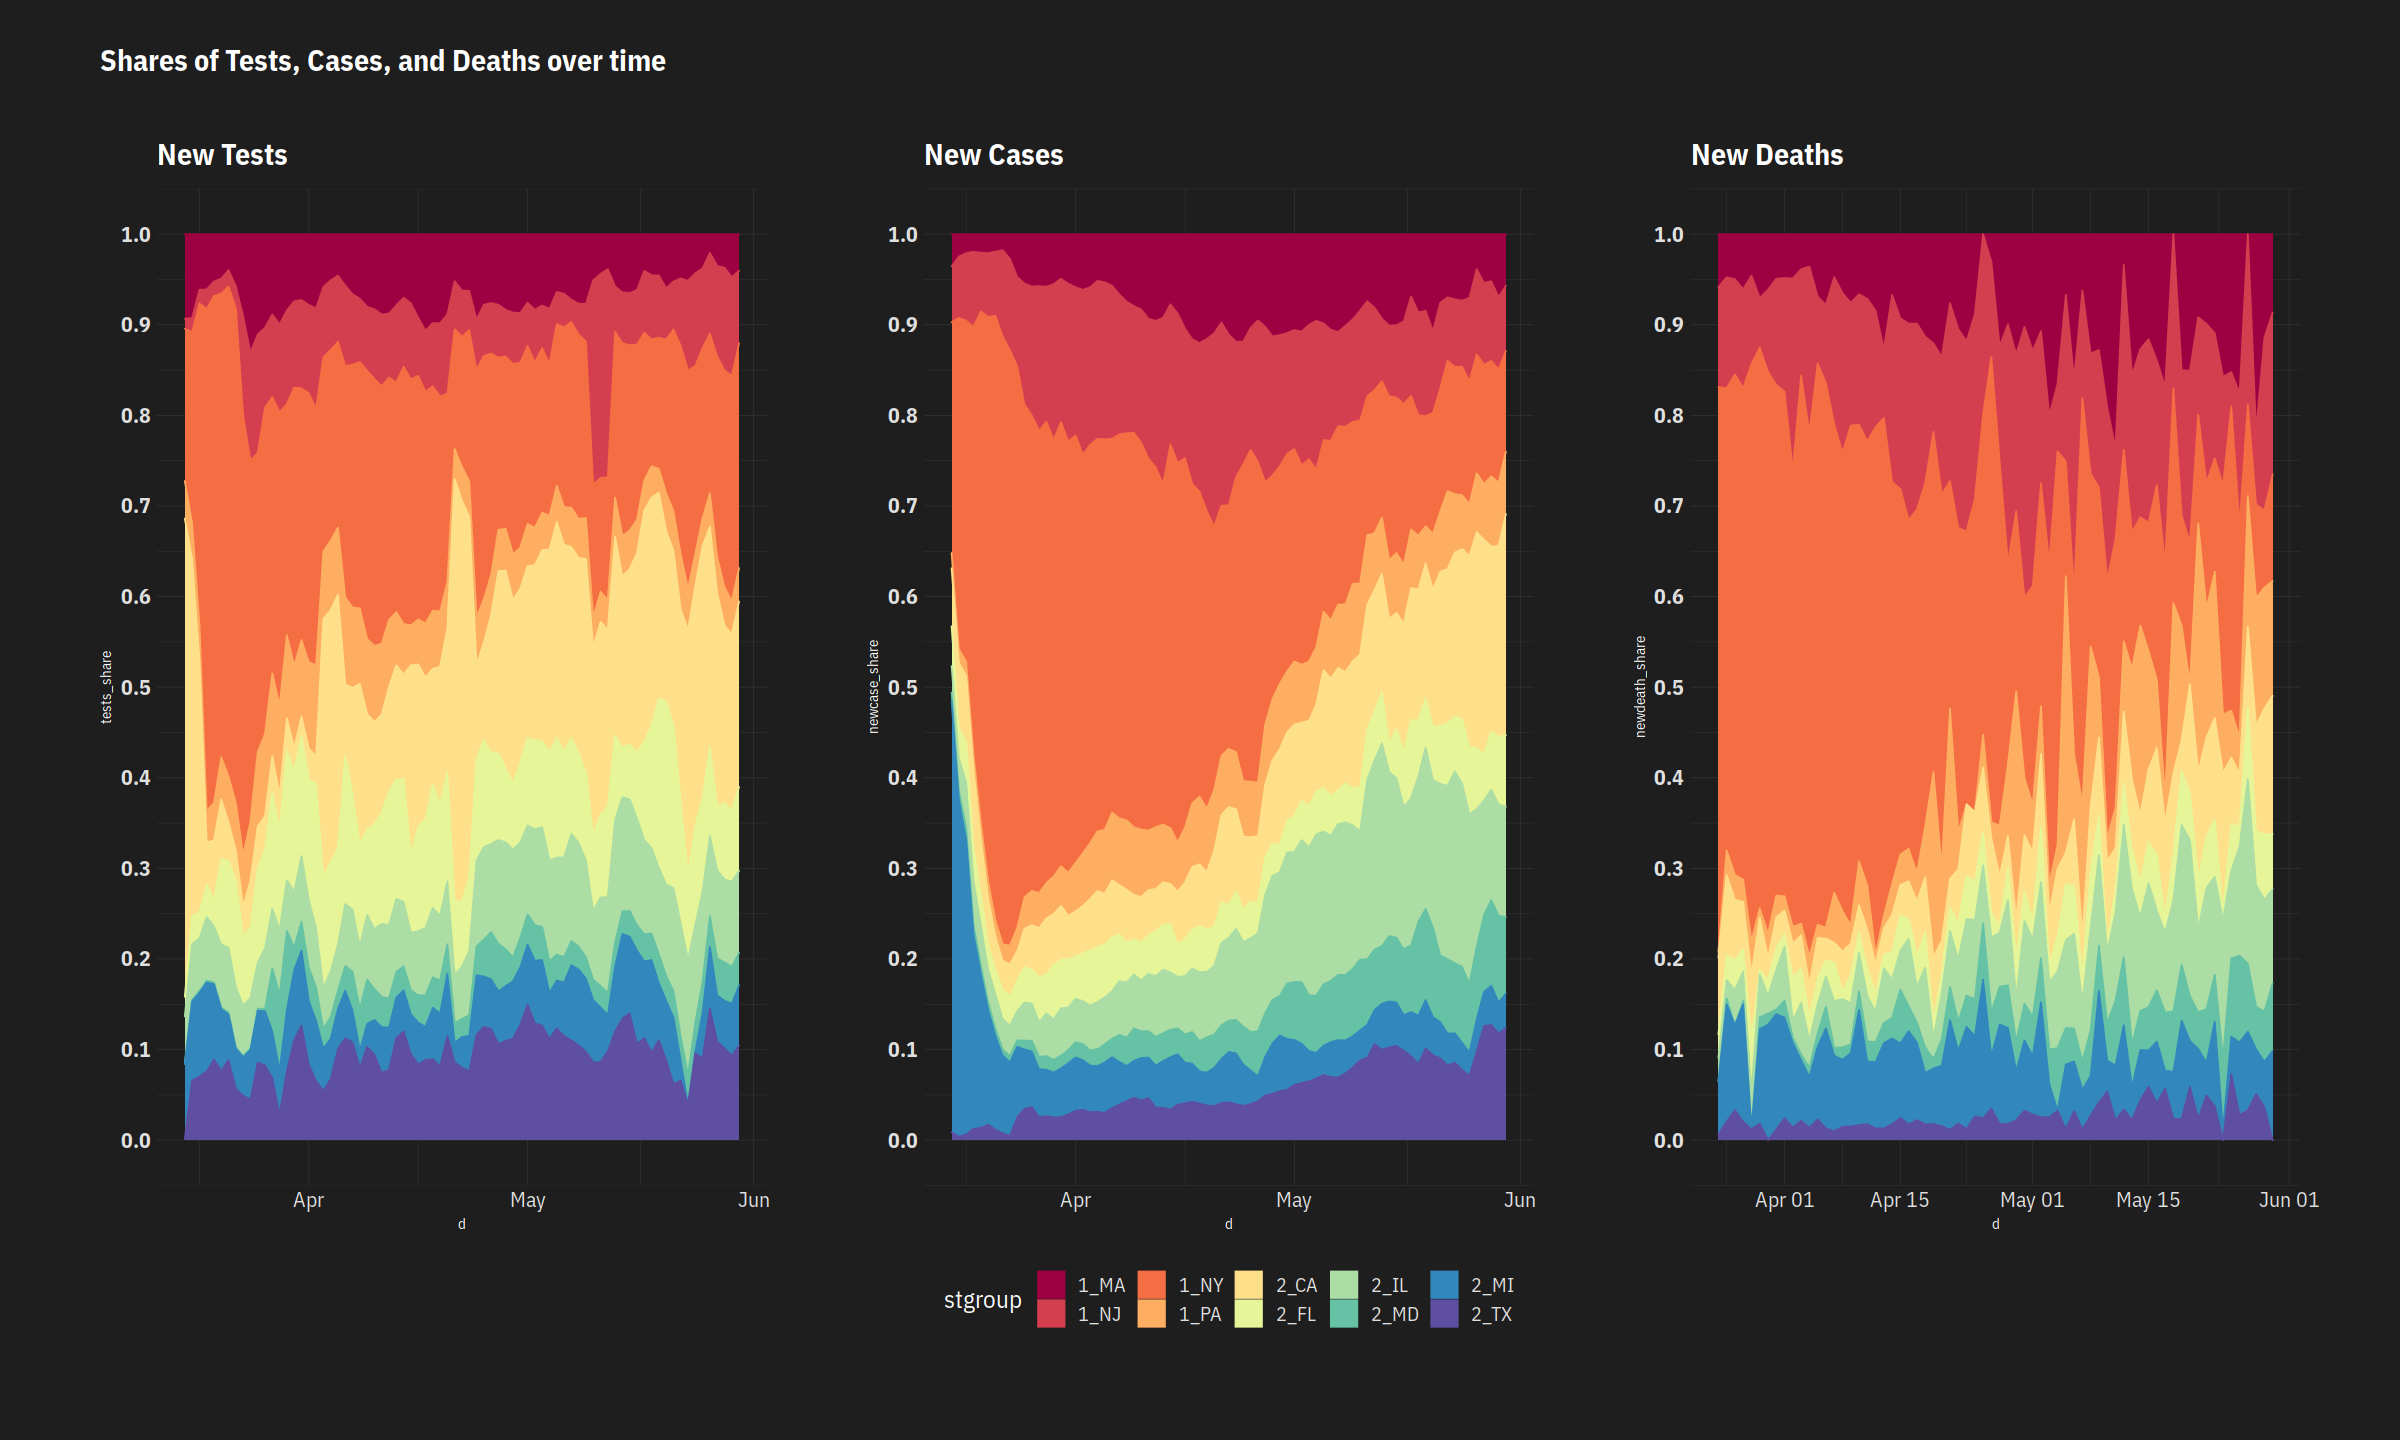

In [20]:
p1 = ggplot(t10states[d >= "2020-03-15"], aes(x = d, y = newcase_share, fill = stgroup, colour = stgroup)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases")
p2 = ggplot(t10states[d >= "2020-03-24"], aes(x = d, y = newdeath_share, fill = stgroup, colour = stgroup)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    theme(legend.position = "None") + 
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Deaths")
p3 = ggplot(t10states[d >= "2020-03-15"], aes(x = d, y = tests_share, fill = stgroup, colour = stgroup)) +
    geom_area(position="fill") +
    theme(legend.position = "None") + 
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Tests")
options(repr.plot.width = 20, repr.plot.height = 12)
(p3 | p1 | p2 ) + plot_annotation(title = "Shares of Tests, Cases, and Deaths over time")

## TPR

In [21]:
options(repr.plot.width = 15, repr.plot.height = 10)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


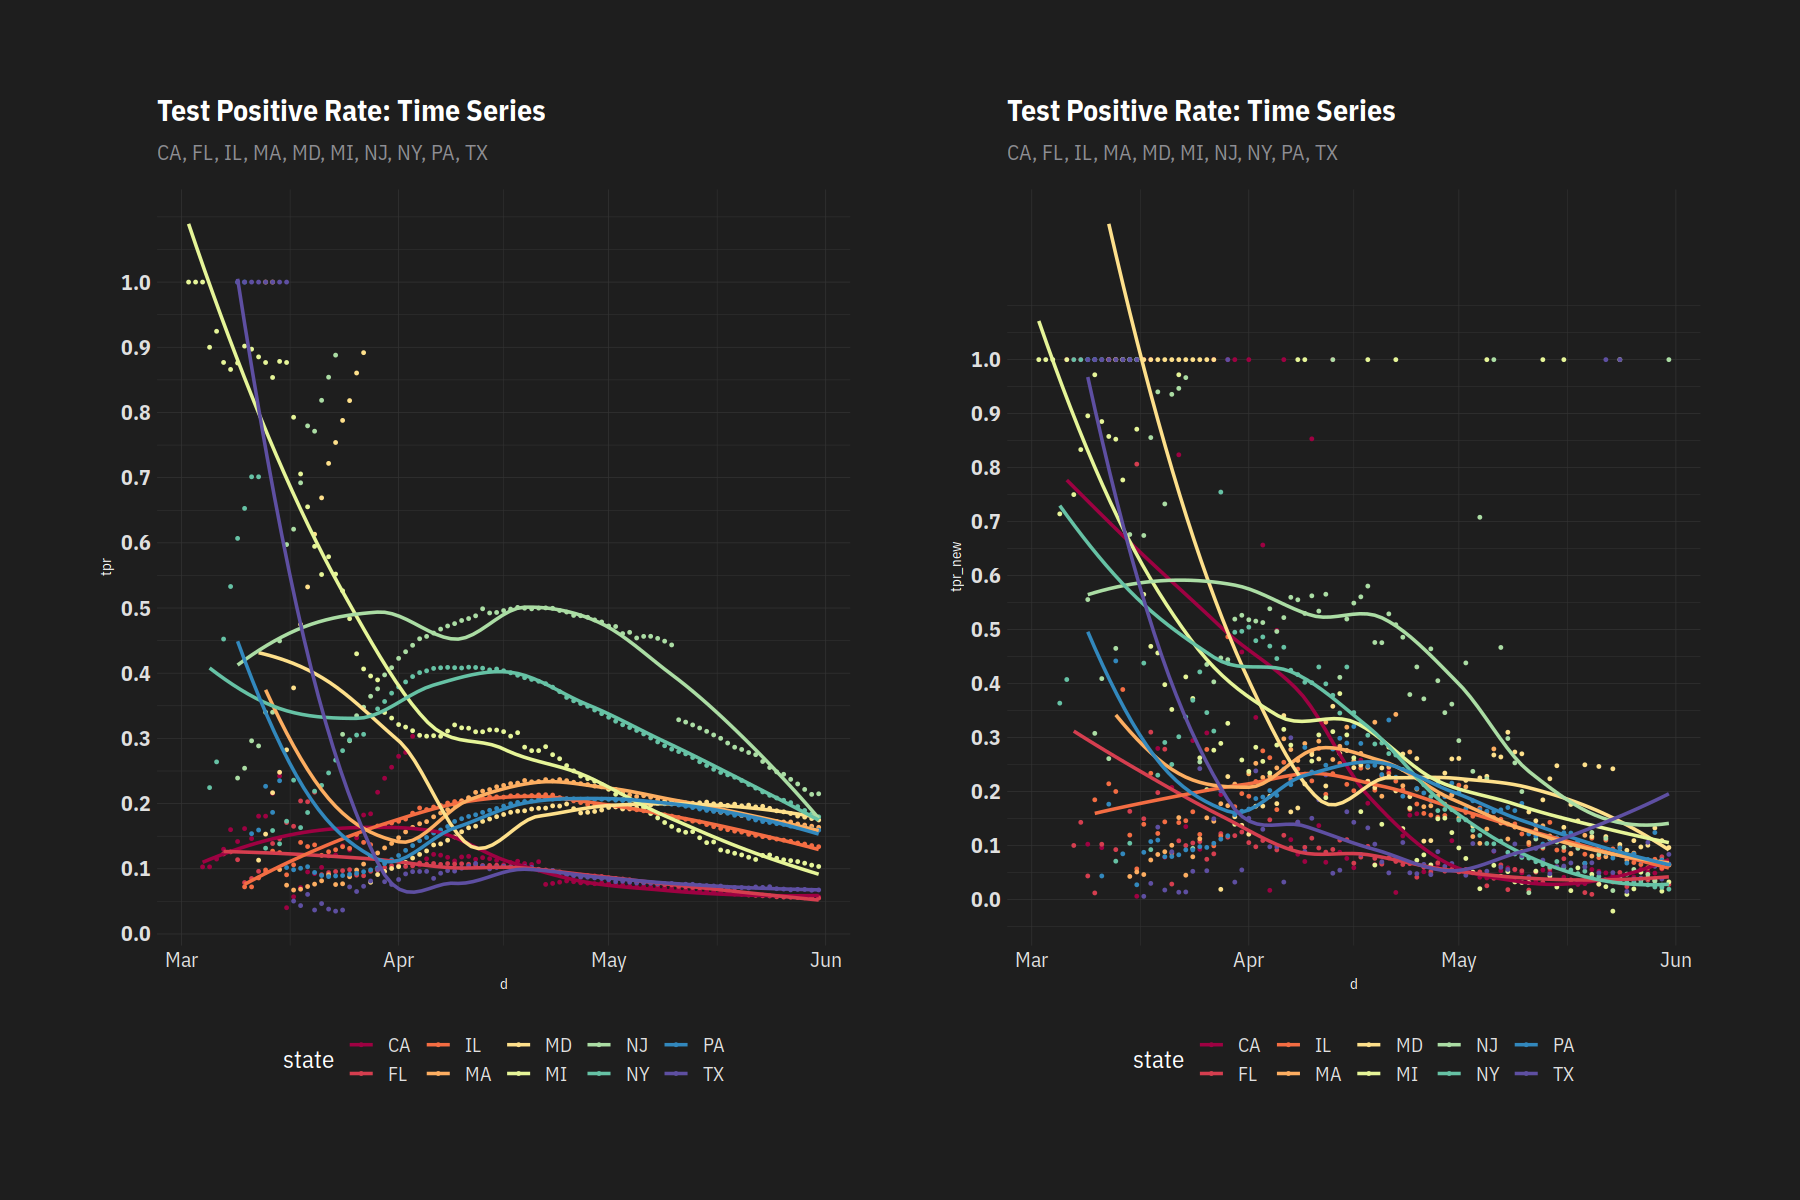

In [22]:
p1 = plot_ts(t10states, 'tpr', "Test Positive Rate: Time Series", T, F) +
    scale_y_continuous(breaks = seq(0, 1, .1))

p2 = plot_ts(t10states, 'tpr_new', "Test Positive Rate: Time Series", T, F) +
    scale_y_continuous(breaks = seq(0, 1, .1))

p1 | p2 

# Day-of-week effects 

In [23]:
dt = t10states[d >= '2020-03-15']
dt[, wknd := ifelse(day %in% c("Saturday", "Sunday"), 1, 0)]
dt[, t := date - 20200315] # time trend 
dt$day2 = as.factor(dt$day) 

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 5 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


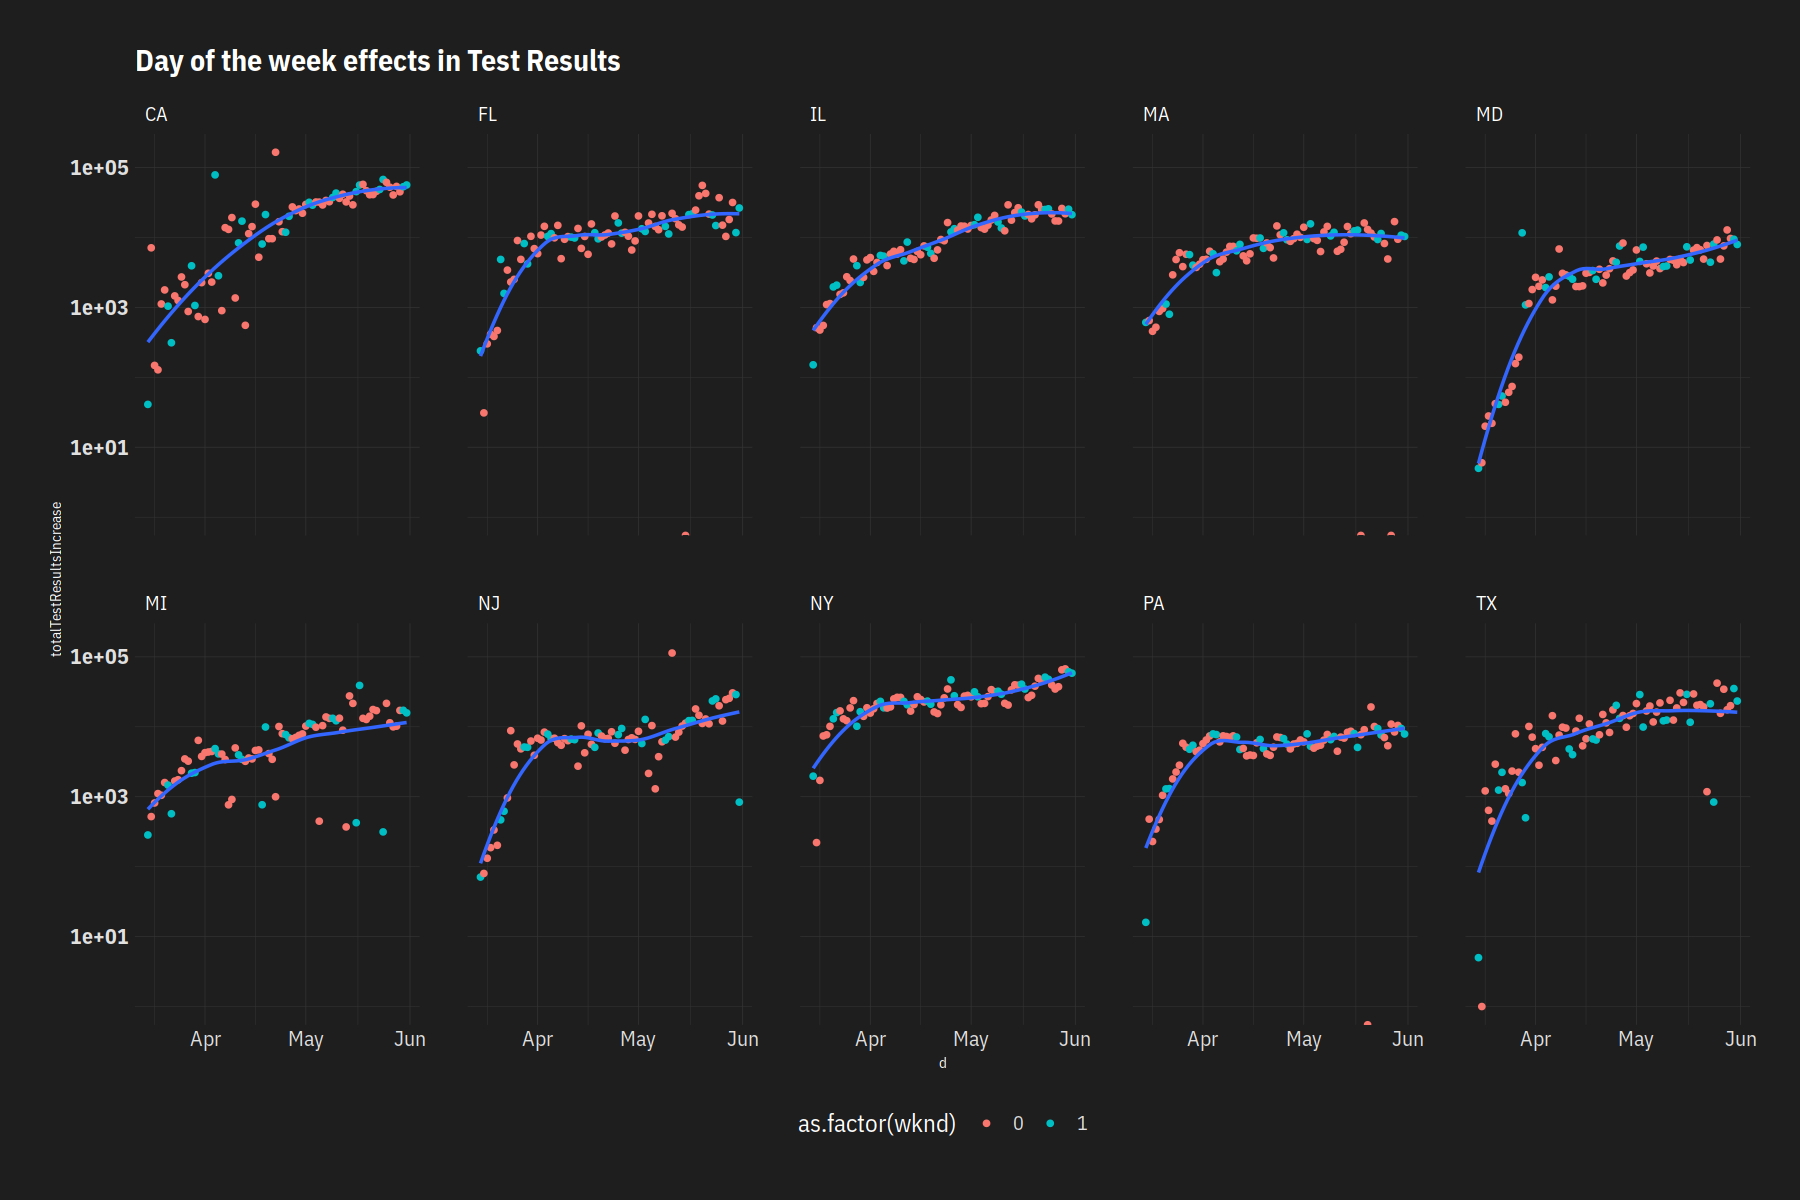

In [24]:
(p = ggplot(dt, aes(d, y = totalTestResultsIncrease)) +
    geom_point(aes(colour = as.factor(wknd))) + 
    geom_smooth(se = F) +
    labs(title = "Day of the week effects in Test Results") +
    facet_wrap(~ state, 2) +
    scale_y_log10()
)

In [25]:
day_of_week_plot = function(df){
    d = df %>% filter(term != "(Intercept)") %>% 
        mutate(day = str_replace(term, "relevel\\(day2, 2\\)", "")) %>% 
        mutate(ord_day = case_when(
            day == "Monday" ~ 1,  day == "Tuesday" ~ 2,  day == "Wednesday" ~ 3,  day == "Thursday" ~ 4, 
            day == "Friday" ~ 5,  day == "Saturday" ~ 6,  day == "Sunday" ~ 7
        ), wknd = as.factor(ifelse(day %in% c("Saturday", "Sunday"), 1, 0))) %>% 
        mutate(ub = estimate + 1.96 * `std.error`, 
               lb = estimate - 1.96 * `std.error`)
    stname = unique(df$state)
    p = ggplot(d, aes(x = ord_day,y = estimate, colour = wknd)) +
        geom_point() + 
        theme(legend.position = "None") +
        geom_pointrange(aes(ymin = lb, ymax = ub)) + 
        labs(title = stname)
}

Warning message in log(totalTestResultsIncrease + 1):
“NaNs produced”


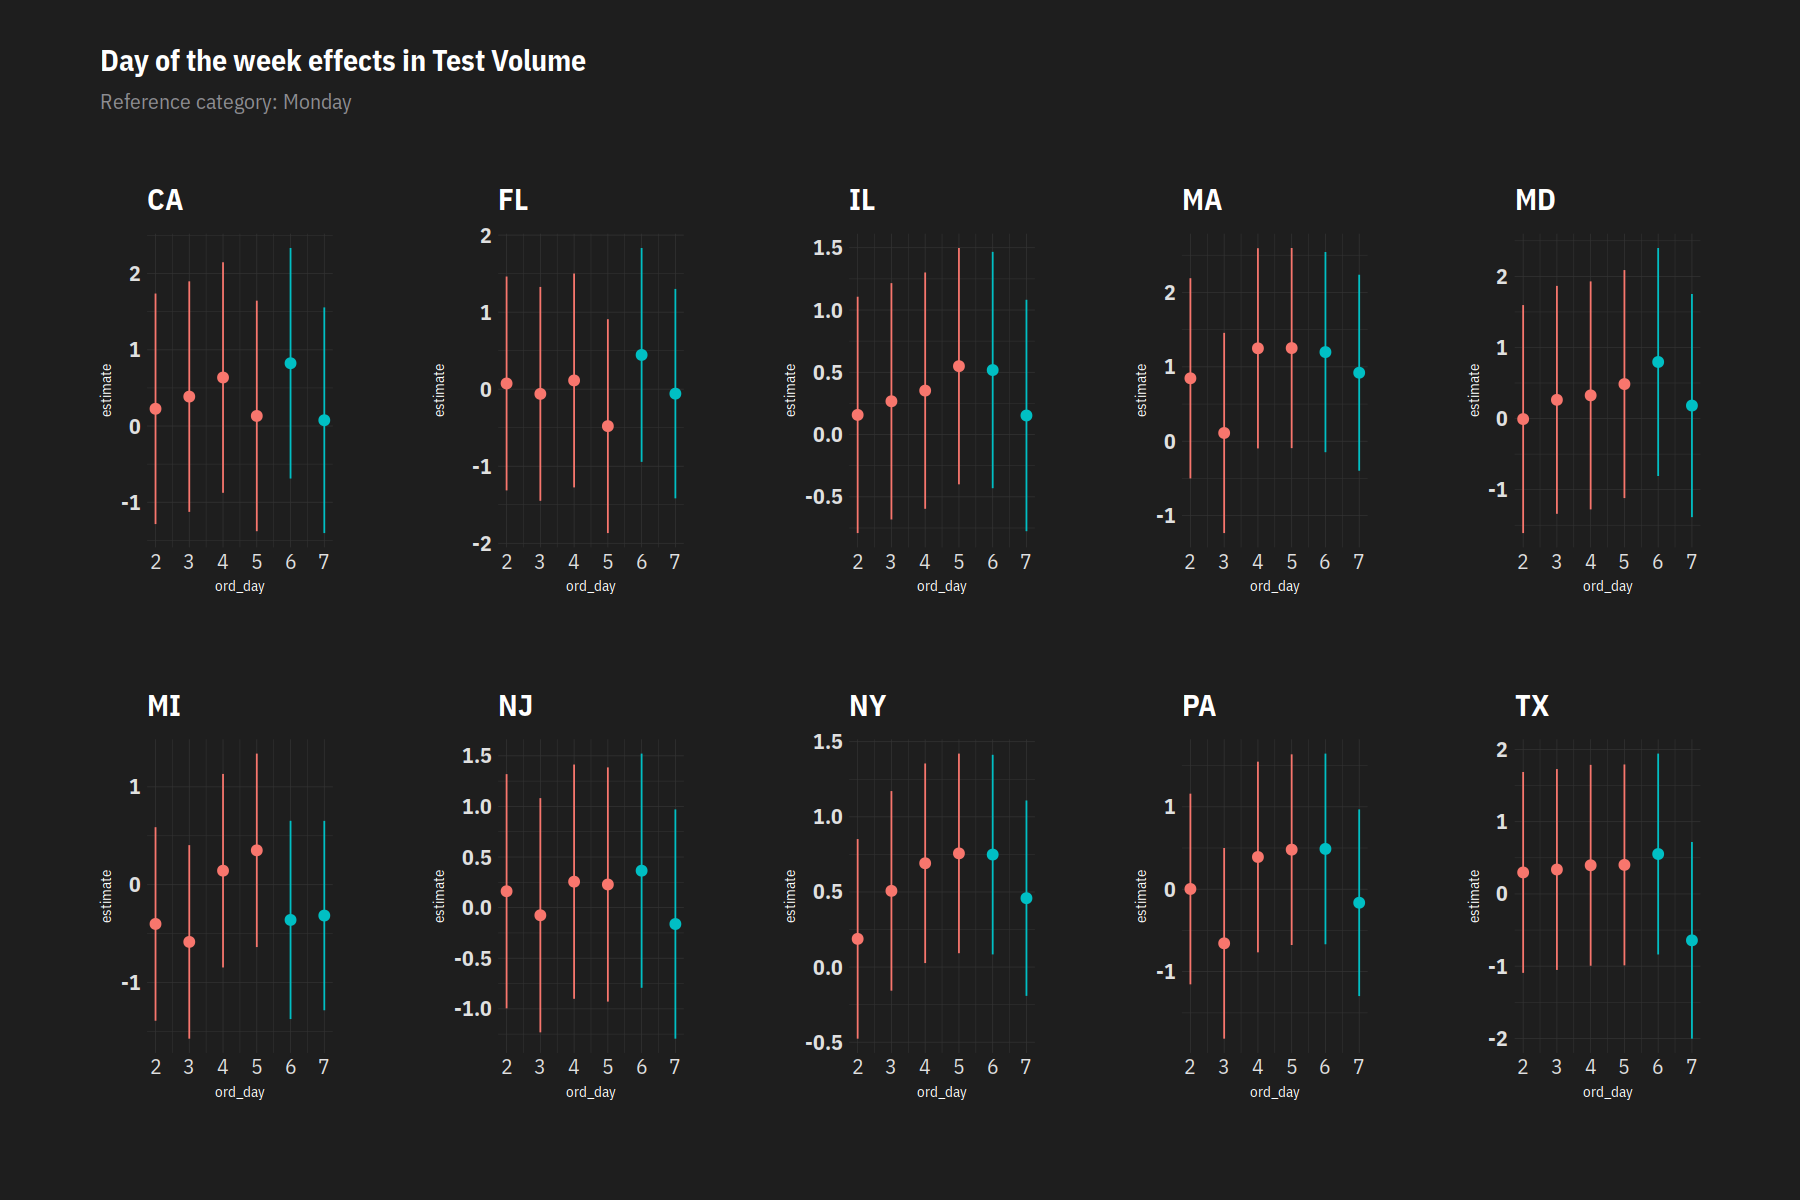

In [26]:
test_increase_regs = dt %>% group_by(state) %>% group_map( ~ lm(log(totalTestResultsIncrease+1) ~ relevel(day2, 2), .x) %>% 
                tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(test_increase_regs , day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in Test Volume',
    subtitle = 'Reference category: Monday',
)

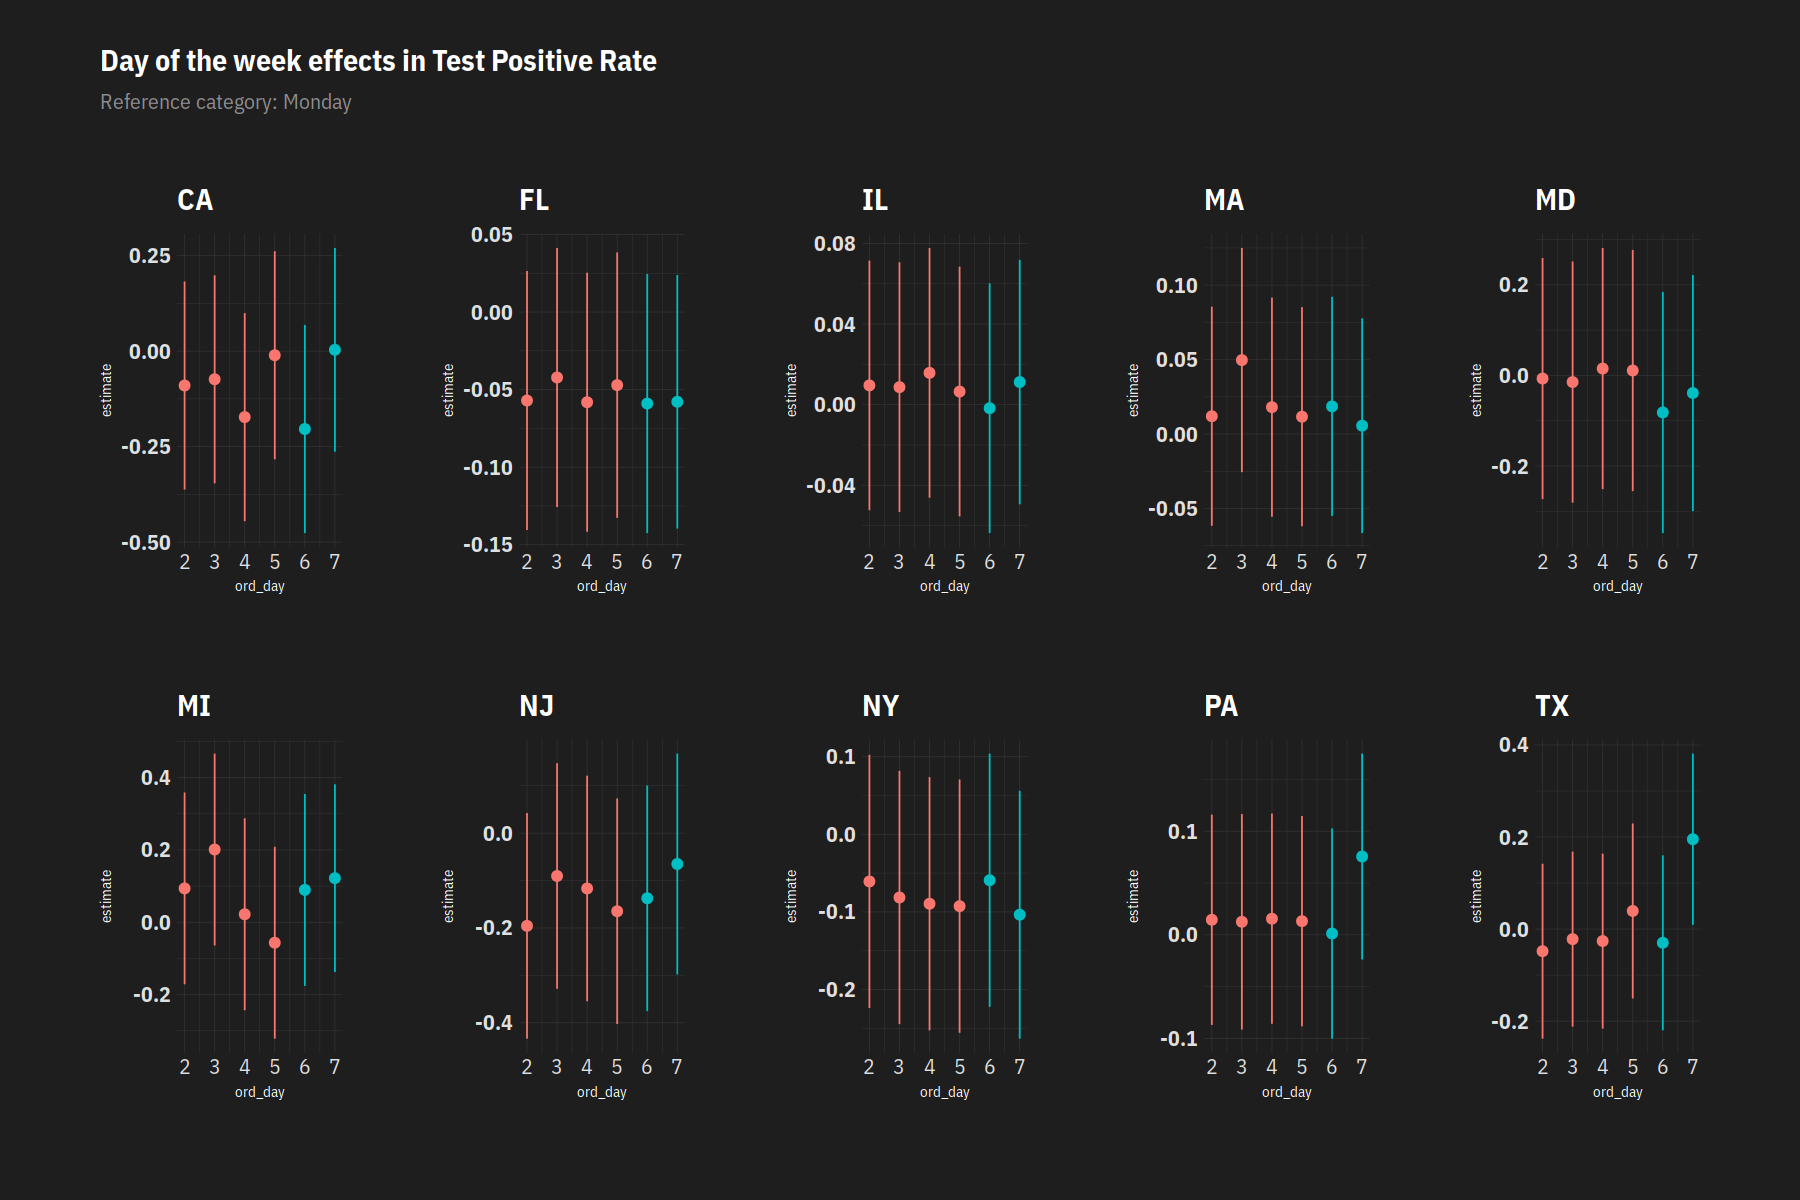

In [27]:
positive_rate = dt %>% group_by(state) %>% group_map( ~ lm(tpr_new ~ relevel(day2, 2), .x) %>% tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(positive_rate, day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in Test Positive Rate',
    subtitle = 'Reference category: Monday',
)

Warning message in log(deathIncrease + 1):
“NaNs produced”


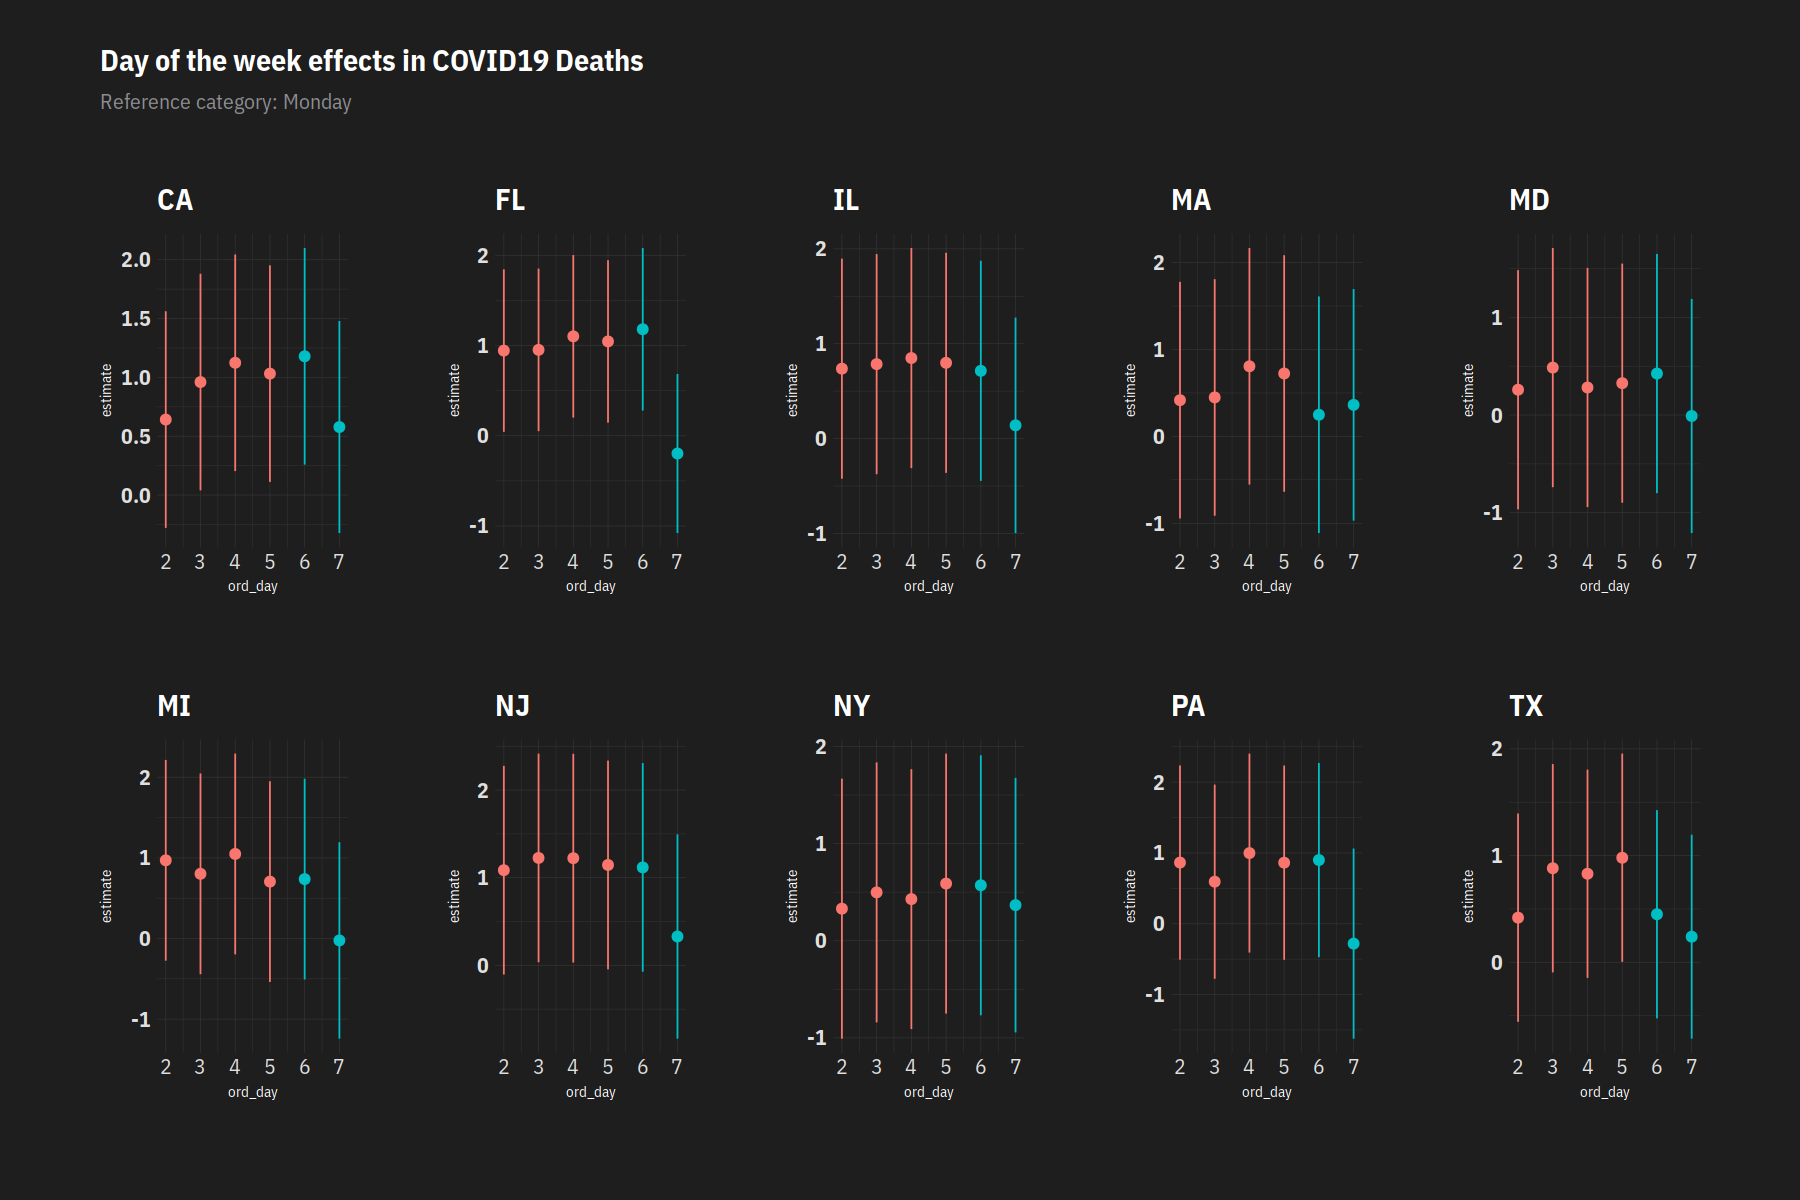

In [28]:
dths = dt %>% group_by(state) %>% group_map( ~ lm(log(deathIncrease+1) ~ relevel(day2, 2), .x) %>% tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(dths, day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in COVID19 Deaths',
    subtitle = 'Reference category: Monday',
)